# Reinforcement learning vs Traditional Strategies on Brent Crude Prices (BZ=F)
This notebook created to demonstrate the application of reinforcement learning algorithms (DQN, PG and optionally A2C) for algorithmic trading using historical Brent crude oil data (BZ=F). It also includes baseline strategies, feature engineering, environment simulation, model training, evaluation, and performance comparison.



It should be noticed that I ran and designed this python notebook on google colab and explanations are provided inside codes as much as possible to help the reader understand what we are doing in each box of code.
Steps taken in this notebook to compare **Reinforcement Learning agents** with **traditional strategies** on Brent Crude Oil prices are as follows:

- Load and clean data (NaNs removed)
- Feature engineering (returns, SMA/EMA, MACD, RSI, volatility and using normalized volume).
- **Train / Validation / Test** split.
- A  **TradingEnv** with transaction costs and long only (no short sell)
- Two RL agents written **from scratch** in PyTorch:
  - **DQN** (discrete actions: {-1, 0, +1} position)
  - **REINFORCE** (policy gradient)
- Baselines: **SMA crossover** and **MACD**.
- Metrics: CAGR, Sharpe, Sortino, Max Drawdown, Volatility
- Plots for side-by-side comparison.

I downloaded the data using python yfinance library, and saved it in CSV format it looks like this:

| Date       | Close       | High        | Low         | Open        | Volume |
|------------|-------------|-------------|-------------|-------------|--------|
| 30/07/2007 | 75.73999786 | 76.52999878 | 75.44000244 | 75.84999847 | 2575   |
| 31/07/2007 | 77.05000305 | 77.16999817 | 75.66999817 | 75.69999695 | 3513   |
| 01/08/2007 | 75.34999847 | 77.05999756 | 74.86000061 | 77.00000000 | 3930   |
| 02/08/2007 | 75.76000214 | 76.20999908 | 74.26999664 | 75.22000122 | 6180   |
| 03/08/2007 | 74.75000000 | 76.00000000 | 74.52999878 | 75.38999939 | 4387   |

The python code that I used to download the data from Yahoo Finance is:

<pre> ```python !pip install yfinance import yfinance as yf # Download Brent Crude Oil (BZ=F) daily data brent = yf.download("BZT=F", start="2007-01-01", end="2025-08-10", interval="1d") print(brent.head()) brent.to_csv("brent_crude_BZT.csv") ``` </pre>

**Importing libraries needed to implement the codes:**

In [ ]:
import numpy as np
import pandas as pd
import random
import math

# Libraries for visualization
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#Libraries needed for neural networks and RL algorithms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.optim as optim

from collections import deque


In [ ]:
# Here we define some constants to be used during our implementation of codes
plt.rcParams['figure.figsize'] = (11, 5)

RANDOM_SEED = 42             # using random seed for reproduciblity
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
symbol = 'Brent BZ=F'

## Step 1: Load and Preprocess Market Data


In [ ]:
#After running this box of code, it prompts to specify the location of CSV file on the computer
# It is needed to click on 'Choose Files' and specify the location
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('Brent_Crude_Oil_BZF.csv')
df = df.rename(columns={'Close': 'price'})
df.dropna(inplace=True)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", infer_datetime_format=True)
df = df.sort_values("Date")
START_DATE = '2010-01-01'
END_DATE = '2025-07-05'
df = df.loc[df["Date"] >= pd.to_datetime(START_DATE)]
df = df.loc[df["Date"] <= pd.to_datetime(END_DATE)]
df = df.dropna()
display(df.head())
print(f"Loaded {len(df)} rows. Date range: {df['Date'].min().date()} -> {df['Date'].max().date()}")


Saving Brent_Crude_Oil_BZF.csv to Brent_Crude_Oil_BZF.csv


/tmp/ipython-input-2842031505.py:8: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/tmp/ipython-input-2842031505.py:8: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,Date,price,High,Low,Open,Volume
592,2010-01-04,80.120003,79.820000,80.120003,80.120003,97
593,2010-01-05,80.589996,80.260002,80.589996,80.589996,97
594,2010-01-06,81.889999,81.699997,80.129997,81.129997,7
595,2010-01-07,81.510002,81.510002,81.629997,81.510002,7
596,2010-01-08,81.370003,81.529999,81.089996,81.370003,7


Loaded 3868 rows. Date range: 2010-01-04 -> 2025-07-04


# **Traditional Baselines**

## SMA-Crossover

**What numbers choose for fsma and ssma?**

In [ ]:
# prep previous data and use grid search on period between 2010 to 2023 (we use 2023 onward to test it)
start = '2010-01-01'
end = '2023-01-01'
df_CO_search = df[df['Date'] >= start].copy()
df_CO_search = df_CO_search[df_CO_search['Date'] <= end]
df_CO_search['Date'] = pd.to_datetime(df_CO_search['Date'])
df_CO_search = df_CO_search.sort_values('Date').set_index('Date')

price = df_CO_search['price'].copy()
start_balance = 1.5e9  # starting capital for scoring

def sma_cross_score(price, fast, slow, fee=3e-5, next_bar=True, start_balance=start_balance):
    fs = price.rolling(fast, min_periods=fast).mean()
    ss = price.rolling(slow, min_periods=slow).mean()
    valid = fs.notna() & ss.notna()

    signal = (fs > ss).astype(int)
    pos = (signal.shift(1) if next_bar else signal).where(valid, 0).fillna(0)

    r = price.pct_change().fillna(0.0)
    pos_prev = pos.shift(1).fillna(0.0)
    turn = pos.diff().abs().fillna(0.0)

    retD = pos_prev * r - fee * turn
    equity = (1 + retD).cumprod()                   # equity indexed to 1.0
    networth = start_balance * equity               # $ net worth series

    vol = retD.std(ddof=1)
    sharpe = np.sqrt(252) * (retD.mean() / vol) if vol > 0 else 0.0
    cagr = (equity.iloc[-1] ** (252/len(retD)) - 1) if len(retD) > 0 else 0.0
    mdd = (equity / equity.cummax() - 1).min()

    final_nw = float(networth.iloc[-1])
    total_pnl = final_nw - start_balance
    cumret = float(equity.iloc[-1] - 1.0)
    trades = int(turn.sum())

    return dict(SMA_m=fast, SMA_n=slow, final_networth=final_nw, total_pnl=total_pnl,
                cumret=cumret, sharpe=float(sharpe), cagr=float(cagr),
                maxdd=float(mdd), trades=trades)

c_fast = [5, 8, 10, 12, 15, 20, 25, 30]
c_slow = [20, 30, 40, 50, 60, 75, 100, 150]
# grid search
rows = []
for f in c_fast:
    for s in c_slow:
        if s < 3 * f:
            continue
        rows.append(sma_cross_score(price, f, s, fee=0, next_bar=True))

grid = pd.DataFrame(rows)

# sort by FINAL NET WORTH first, then SHARPE (both descending)
grid = grid.sort_values(["final_networth", "sharpe"], ascending=[False, False]).reset_index(drop=True)

# Show
Gsearch_result = grid[["SMA_m","SMA_n","final_networth","total_pnl","cumret","sharpe","cagr","maxdd","trades"]]
print(Gsearch_result.head(10).to_string(index=False))

# best pair summary
best = grid.iloc[0]
print(f"\nBest SMA pair: (m={int(best.SMA_m)}, n={int(best.SMA_n)}) | "
      f"Final NW=${best.final_networth:,.0f} | PnL=${best.total_pnl:,.0f} | "
      f"Sharpe={best.sharpe:.3f} | CAGR={best.cagr:.2%} | MaxDD={best.maxdd:.2%}")


 SMA_m  SMA_n  final_networth    total_pnl   cumret   sharpe     cagr     maxdd  trades
     8     30    5.102725e+09 3.602725e+09 2.401817 0.520179 0.099970 -0.437837     114
     8     40    5.055798e+09 3.555798e+09 2.370532 0.538091 0.099179 -0.441713     104
     5     50    4.816879e+09 3.316879e+09 2.211252 0.524509 0.095046 -0.422805     122
    10     40    4.606657e+09 3.106657e+09 2.071105 0.504197 0.091250 -0.440859      92
    10     30    4.573467e+09 3.073467e+09 2.048978 0.484697 0.090636 -0.433710     100
     5     30    4.399287e+09 2.899287e+09 1.932858 0.488123 0.087345 -0.505106     130
    12     40    3.973870e+09 2.473870e+09 1.649247 0.456536 0.078772 -0.376390      86
     5     40    3.943666e+09 2.443666e+09 1.629111 0.448149 0.078132 -0.441034     120
    15     50    3.797188e+09 2.297188e+09 1.531459 0.441804 0.074961 -0.310217      70
     8     50    3.714979e+09 2.214979e+09 1.476653 0.432246 0.073131 -0.476306      90

Best SMA pair: (m=8, n=30) | Fi

In [ ]:
Gsearch_result.head()

,SMA_m,SMA_n,final_networth,total_pnl,cumret,sharpe,cagr,maxdd,trades
0,8,30,5.102725e+09,3.602725e+09,2.401817,0.520179,0.099970,-0.437837,114
1,8,40,5.055798e+09,3.555798e+09,2.370532,0.538091,0.099179,-0.441713,104
2,5,50,4.816879e+09,3.316879e+09,2.211252,0.524509,0.095046,-0.422805,122
3,10,40,4.606657e+09,3.106657e+09,2.071105,0.504197,0.091250,-0.440859,92
4,10,30,4.573467e+09,3.073467e+09,2.048978,0.484697,0.090636,-0.433710,100


In [ ]:
# Defining settings :

# fast simple moving average period
fsma_period = 8  # drived from fast grid search as shown in the above box results

# slow simple moving average period
ssma_period = 30 # drived from fast grid search as shown in the above box results

#TRANSACTION_COST not considered for this strategy; however it can be simply applied in functions we will define later
cost_per_switch=0.000


In [ ]:
#Preparing a dataframe to be used for SMA-crossover detection flags and plotting

start_date ='2023-01-01' # same as start of  test period in evaluation section of RL agents
#df_CO : dataframe to be used for crossover (CO) strategy
df_CO = df[df['Date'] >= start_date].copy()

df_CO["Date"] = pd.to_datetime(df_CO["Date"])
df_CO = df_CO.sort_values("Date").set_index("Date")

df_CO ['slow_sma'] = df_CO['price'].rolling(ssma_period).mean()
df_CO ['fast_sma'] = df_CO['price'].rolling(fsma_period).mean()

df_CO['fast_prev'] = df_CO['fast_sma'].shift(1)
df_CO['slow_prev'] = df_CO['slow_sma'].shift(1)
df_CO = df_CO.dropna()

# events (exact crosses)
bull = (df_CO['fast_prev'] <= df_CO['slow_prev']) & (df_CO['fast_sma'] > df_CO['slow_sma'])
bear = (df_CO['fast_prev'] >= df_CO['slow_prev']) & (df_CO['fast_sma'] < df_CO['slow_sma'])

df_CO['crossover'] = np.where(bull, 'bullish crossover', np.where(bear, 'bearish crossover', None))

# for plotting only the event bars (buy signal or sell signal)
signal_buy = df_CO.loc[df_CO['crossover'] == 'bullish crossover']
signal_sell = df_CO.loc[df_CO['crossover'] == 'bearish crossover']

df_CO.head()

,price,High,Low,Open,Volume,slow_sma,fast_sma,fast_prev,slow_prev,crossover
Date,,,,,,,,,,
2023-02-15,85.379997,85.849998,83.900002,85.290001,21161,83.955333,84.778749,84.098750,83.846000,None
2023-02-16,85.139999,86.199997,84.599998,85.139999,20089,84.198667,85.297500,84.778749,83.955333,None
2023-02-17,83.000000,84.849998,81.790001,84.669998,27191,84.342333,85.211249,85.297500,84.198667,None
2023-02-21,83.050003,84.290001,82.540001,83.010002,31936,84.491667,84.956250,85.211249,84.342333,None
2023-02-22,80.599998,83.230003,80.400002,82.739998,20309,84.523333,84.468750,84.956250,84.491667,bearish crossover


In [ ]:
signal_buy.head()

,price,High,Low,Open,Volume,slow_sma,fast_sma,fast_prev,slow_prev,crossover
Date,,,,,,,,,,
2023-03-07,83.290001,86.760002,82.650002,86.230003,26092,84.227000,84.23250,84.09750,84.390333,bullish crossover
2023-04-05,84.989998,85.550003,84.010002,85.099998,28362,80.277666,81.11875,79.86875,80.131333,bullish crossover
2023-07-10,77.690002,78.779999,77.339996,78.489998,21082,75.227666,75.90625,75.22750,75.250000,bullish crossover
2023-09-01,88.550003,88.959999,86.739998,86.820000,33224,85.001333,85.27875,84.71375,84.751999,bullish crossover
2023-12-27,79.650002,81.320000,79.489998,80.739998,8282,78.884333,79.07625,78.69625,78.978333,bullish crossover


In [ ]:
signal_sell.head()

,price,High,Low,Open,Volume,slow_sma,fast_sma,fast_prev,slow_prev,crossover
Date,,,,,,,,,,
2023-02-22,80.599998,83.230003,80.400002,82.739998,20309,84.523333,84.468750,84.956250,84.491667,bearish crossover
2023-03-13,80.769997,83.470001,78.339996,82.540001,38195,83.607666,83.481250,83.923750,83.804000,bearish crossover
2023-04-28,79.540001,79.599998,77.970001,78.309998,26788,80.925667,80.622501,81.276251,80.764334,bearish crossover
2023-08-29,85.489998,85.650002,83.779999,84.379997,14579,84.297999,84.281250,84.110001,84.102666,bearish crossover
2023-10-06,84.580002,84.959999,83.449997,84.220001,41254,90.617666,90.416249,91.588749,90.576999,bearish crossover


In [ ]:
# Visulaize (-1) Signals using plotly.express

fig = px.line (df_CO, y = ['price', 'fast_sma', 'slow_sma'], title = 'Bearish signals for histotical brent crude oil price')

for idx, row in signal_sell.iterrows():
  fig.add_vline(x=idx)

fig.show()

In [ ]:
# Visulaize (+1) Signals using plotly.express

fig = px.line (df_CO, y = ['price', 'fast_sma', 'slow_sma'], title = 'Bullish signals for histotical brent crude oil price')

for idx, row in signal_buy.iterrows():
  fig.add_vline(x=idx)

fig.show()

Here, we define classes/methods to simulate trading based on the SMA-Cross over strategy, where we buy and sell at trading signals and calculate the profit and loss accordingly. We start with a balance of 1.5e9 similar to what we will use for RL strategies. We also defined a position alocator based on ATR  that lets to buy based on risk tollerance of trader.

## SMA Crossover and MACD Trading Simulator

In [ ]:
# SMA Crossover strategy using ATR-Based Position sizing and stops
# To know more about these classes please refer to the thesis section related to SMA-Crossover simulation
# ATR?
ATR_WINDOW = 14  #  norm is 14 days in the literature

# work on a copy; keep the original df intact
df_CO = df_CO.copy()
df_CO["prev_close"] = df_CO["price"].shift(1)

# True Range components based on Wilder,1978, Van Tharp and Alexander Elder
tr1 = df_CO["High"] - df_CO["Low"]
tr2 = (df_CO["High"] - df_CO["prev_close"]).abs()
tr3 = (df_CO["Low"] - df_CO["prev_close"]).abs()

# TR = max of intraday range and gap ranges
df_CO["true_range"] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

# Pandas EWM with adjust=False uses y_t​=αx_tt​+(1−α)y_{t−1} ​, if we set a=1/n and take x_t=TR_t we reach the same formula we have in the thesis:
# TRt=  ((n-1) 〖ATR〗_(t-1)+〖TR〗_t)/n
df_CO["ATR"] = df_CO["true_range"].ewm(alpha=1/ATR_WINDOW, adjust=False).mean()

# droping initialisation rows so ATR is defined
df_CO = df_CO.dropna(subset=["ATR"])


In [ ]:
# Trade object ########################
class Position:
    """Represents a single trade (long-only here)."""

    def __init__(
        self,
        open_datetime,
        open_price: float,          # $ per barrel
        order_type: str,            # 'buy'
        volume: int,                # number of contracts
        stop_price: float,
        contract_mult: float = 1.0  # barrels per contract (e.g., 1000 for CL/Brent)
    ):
        self.open_datetime = open_datetime
        self.open_price = float(open_price)
        self.order_type = order_type
        self.volume = int(volume)
        self.contract_mult = float(contract_mult)

        self.stop_price = float(stop_price) if stop_price is not None else None
        self.close_datetime = None
        self.close_price = None
        self.profit = 0.0
        self.status = "open"

    def close_position(self, close_datetime, close_price: float) -> None:
        self.close_datetime = close_datetime
        self.close_price = float(close_price)
        if self.order_type == "buy":
            px_diff = self.close_price - self.open_price
        else:
            px_diff = self.open_price - self.close_price
        # PnL in account currency: ($/bbl) * (contracts) * (bbl/contract)
        self.profit = px_diff * self.volume * self.contract_mult
        self.status = "closed"

    def unrealized_pnl(self, mark_price: float) -> float:
        if self.status != "open":
            return 0.0
        m = float(mark_price)
        if self.order_type == "buy":
            px_diff = m - self.open_price
        else:
            px_diff = self.open_price - m
        return px_diff * self.volume * self.contract_mult

    def _asdict(self) -> dict:
        return {
            "open_datetime": self.open_datetime,
            "open_price": self.open_price,
            "order_type": self.order_type,
            "volume": self.volume,
            "stop_price": self.stop_price,
            "close_datetime": self.close_datetime,
            "close_price": self.close_price,
            "profit": self.profit,
            "status": self.status,
            "contract_mult": self.contract_mult,
        }


################  Strategy #################################
class Strategy:
    """
    Simple event-driven loop:
      - enforce ATR stop first
      - act on SMA crossover: bullish=open long, bearish=close long
      - optional: one open position at a time
    """

    def __init__(
        self,
        df: pd.DataFrame,
        starting_balance: float,
        volume: int = None,      # contracts if no sizer provided
        position_sizer=None,               # callable(ts, row, equity) -> units (contracts)
        one_at_a_time: bool = True,
        use_atr_stop: bool = True,
        stop_k_atr: float = 3.0,
        contract_mult: float = 1000.0         # barrels per contract
    ):
        self.starting_balance = float(starting_balance)
        self.volume = volume
        self.position_sizer = position_sizer
        self.positions: List[Position] = []
        self.data = df
        self.one_at_a_time = bool(one_at_a_time)
        self.use_atr_stop = bool(use_atr_stop)
        self.stop_k_atr = float(stop_k_atr)
        self.default_contract_mult = float(contract_mult)

    def realized_equity(self) -> float:
        realized = sum((p.profit or 0.0) for p in self.positions if p.status == "closed")
        return self.starting_balance + realized

    def account_equity(self, mark_price: float) -> float:
        eq = self.realized_equity()
        eq += sum(p.unrealized_pnl(mark_price) for p in self.positions if p.status == "open")
        return eq

    def get_positions_df(self) -> pd.DataFrame:
        trades = pd.DataFrame([p._asdict() for p in self.positions])
        if trades.empty:
            return trades
        trades["pnl"] = trades["profit"].cumsum() + self.starting_balance
        return trades

    def add_position(self, position: Position) -> bool:
        if self.one_at_a_time and any(p.status == "open" for p in self.positions):
            return False
        self.positions.append(position)
        return True

    def _enforce_stops(self, ts, row: pd.Series) -> None:
        if not self.use_atr_stop:
            return
        # use intraday low for breach detection if available
        low_px = float(row["Low"]) if "Low" in row else float(row["price"])
        for p in self.positions:
            if p.status == "open" and p.stop_price is not None and low_px <= p.stop_price:
                # conservative fill for LONG: worst is the lower of stop vs close
                fill_px = min(p.stop_price, float(row["price"]))
                p.close_position(ts, fill_px)

    def run(self, force_close_end: bool = True) -> pd.DataFrame:
        for ts, row in self.data.iterrows():
            price = float(row["price"])

            # 1) stops first
            self._enforce_stops(ts, row)

            # 2) act on crossover signal
            if row.get("crossover") == "bearish crossover":
                for p in self.positions:
                    if p.status == "open":
                        p.close_position(ts, price)

            if row.get("crossover") == "bullish crossover":
                if self.position_sizer is not None:
                    units = self.position_sizer(ts, row, self.account_equity(price))  # contracts
                    contract_mult = getattr(self.position_sizer, "contract_mult", self.default_contract_mult)
                else:
                    units = self.volume if self.volume is not None else 0
                    contract_mult = self.default_contract_mult

                if units and units > 0:
                    stop_px = None
                    if self.use_atr_stop:
                        atr = float(row.get("ATR", 0.0))
                        if atr > 0:
                            stop_px = price - self.stop_k_atr * atr
                    self.add_position(
                        Position(
                            ts, price, "buy", int(units), stop_price=stop_px,
                            contract_mult=contract_mult))

        # 3) clean up at end
        if force_close_end and len(self.data) > 0:
            last_ts = self.data.index[-1]
            last_px = float(self.data.iloc[-1]["price"])
            for p in self.positions:
                if p.status == "open":
                    p.close_position(last_ts, last_px)

        return self.get_positions_df()


# ATR risk-per-trade sizer class
class ATRRiskSizer:
    """
    Units so that, if an ATR stop hits, loss ≈ risk_pct * equity:
      units = floor( risk_pct * equity / (k_atr * ATR * contract_mult) ) rounded to lot_size
    """

    def __init__(
        self,
        risk_pct: float = 0.02,
        k_atr: float = 3.0,
        contract_mult: float = 1000.0,  # e.g., CL/Brent = 1000 bbl/contract
        lot_size: int = 1,
    ):
        self.risk_pct = float(risk_pct)
        self.k_atr = float(k_atr)
        self.contract_mult = float(contract_mult)
        self.lot_size = int(lot_size)

    def __call__(self, ts, row: pd.Series, equity: float) -> int:
        atr = float(row.get("ATR", 0.0))
        if atr <= 0 or equity <= 0:
            return 0
        # risk per ONE contract assuming stop at k_atr * ATR
        per_unit_risk = self.k_atr * atr * self.contract_mult
        raw_units = (self.risk_pct * equity) / max(per_unit_risk, 1e-12)
        # enforce lot size (contracts must be multiples of lot_size)
        units = math.floor(raw_units / self.lot_size) * self.lot_size
        return max(int(units), 0)


# we use above like this:
# sizer = ATRRiskSizer(risk_pct=0.02, k_atr=3.0, contract_mult=1000.0, lot_size=1)
# strat = Strategy(
#     df=df_CO,                                # DataFrame with columns: 'price', 'ATR', optional 'Low', 'crossover'
#     starting_balance=1.5e9 ,
#     position_sizer=sizer,                    # uses sizer; if None, provide volume (contracts) and contract_mult in Strategy
#     one_at_a_time=True,
#     use_atr_stop=True,
#     stop_k_atr=3.0,
#     contract_mult=1000.0)
# trades = strat.run()
# print(trades.tail())


In [ ]:
# Use the same k_atr here and in Strategy to keep risk bound consistent
sizer = ATRRiskSizer(risk_pct=0.02, k_atr=3.0, contract_mult=1000.0, lot_size=1)

sma_crossover_strategy = Strategy(
    df_CO,
    starting_balance=1.5e9 ,
    position_sizer=sizer,
    one_at_a_time=True,
    use_atr_stop=True,
    stop_k_atr=3.0)

result = sma_crossover_strategy.run()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(df_CO, y=['price', 'fast_sma', 'slow_sma'])

# BUY signals: green dashed, labeled
for idx, _ in signal_buy.iterrows():
    x = pd.to_datetime(idx)
    fig.add_shape(type="line", x0=x, x1=x, y0=0, y1=1, xref="x", yref="paper",
                  line=dict(color="seagreen", width=1.5, dash="dash"), opacity=0.7)

for idx, _ in signal_sell.iterrows():
    x = pd.to_datetime(idx)
    fig.add_shape(type="line", x0=x, x1=x, y0=0, y1=1, xref="x", yref="paper",
                  line=dict(color="crimson", width=1.5, dash="dot"), opacity=0.7)

# trade PnL segments (as we had)
for i, row in result[result['status'] == 'closed'].iterrows():
    fig.add_shape(
        type="line",
        x0=row.open_datetime, y0=row.open_price,
        x1=row.close_datetime, y1=row.close_price,
        line=dict(color=("Green" if row.profit > 0 else "Red"), width=3)
    )

# make graph informative by adding legend entries for the vlines (shapes don't appear in legends)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines',
                         line=dict(color='seagreen', dash='dash'),
                         name='Buy signal'))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines',
                         line=dict(color='crimson', dash='dot'),
                         name='Sell signal'))

fig.show()


/tmp/ipython-input-2069364701.py:7: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



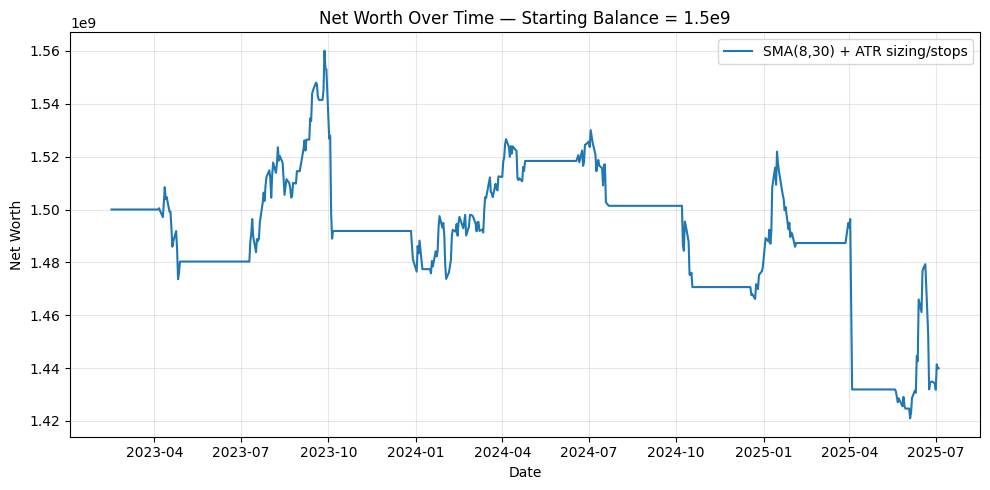

   open_datetime  open_price order_type  volume  stop_price close_datetime  \
6     2024-10-07   80.930000        buy    3908   73.246599     2024-10-18   
7     2024-12-18   73.389999        buy    5932   68.432493     2025-02-04   
8     2025-03-28   73.629997        buy    6883   69.308878     2025-04-04   
9     2025-05-19   65.540001        buy    4410   59.046604     2025-05-30   
10    2025-06-03   65.629997        buy    4802   59.697047     2025-07-03   

    close_price        profit  status  contract_mult           pnl  
6     73.059998 -3.075597e+07  closed         1000.0  1.470643e+09  
7     76.199997  1.666891e+07  closed         1000.0  1.487312e+09  
8     65.580002 -5.540812e+07  closed         1000.0  1.431904e+09  
9     63.900002 -7.232397e+06  closed         1000.0  1.424672e+09  
10    68.800003  1.522237e+07  closed         1000.0  1.439894e+09  
Final Net Worth: 1439893928.7841


In [ ]:
# 1- build a simple SMA(8,30) crossover signal (because we will use it a couple of time, building a function is helpfull for clarity
def add_sma_crossover(df: pd.DataFrame, fast: int = 8, slow: int = 30, price_col: str = "price") -> pd.DataFrame:
    out = df.copy()
    out["SMA_fast"] = out[price_col].rolling(fast, min_periods=fast).mean()
    out["SMA_slow"] = out[price_col].rolling(slow, min_periods=slow).mean()
    above = out["SMA_fast"] > out["SMA_slow"]
    above_prev = above.shift(1).fillna(False)
    out["crossover"] = None
    out.loc[( above) & (~above_prev), "crossover"] = "bullish crossover"
    out.loc[(~above) & ( above_prev), "crossover"] = "bearish crossover"
    return out

# 2- helper: reconstruct Net Worth time series (realized + unrealized) from trades
def reconstruct_net_worth_from_trades(price_series: pd.Series,
                                      trades_df: pd.DataFrame,
                                      starting_balance: float,
                                      contract_mult: float = 1000.0) -> pd.Series:
    price = price_series.copy().sort_index()
    nw = pd.Series(index=price.index, dtype=float)
    realized = 0.0
    open_pos = None  # {"open_px": float, "vol": int}

    closes_by_date, opens_by_date = {}, {}
    if trades_df is not None and not trades_df.empty:
        for _, row in trades_df.iterrows():
            od = pd.to_datetime(row["open_datetime"])
            opens_by_date.setdefault(od, []).append(row)
            if pd.notna(row.get("close_datetime")):
                cd = pd.to_datetime(row["close_datetime"])
                closes_by_date.setdefault(cd, []).append(row)

    for ts, px in price.items():
        if ts in closes_by_date and open_pos is not None:
            for row in closes_by_date[ts]:
                realized += (float(row["close_price"]) - open_pos["open_px"]) * open_pos["vol"] * contract_mult
                open_pos = None

        if ts in opens_by_date and open_pos is None:
            row = opens_by_date[ts][-1]
            open_pos = {"open_px": float(row["open_price"]), "vol": int(row["volume"])}

        unreal = (px - open_pos["open_px"]) * open_pos["vol"] * contract_mult if open_pos is not None else 0.0
        nw.loc[ts] = starting_balance + realized + unreal

    return nw.ffill()

# 3- Prepare data: ensure datetime index and add crossover
df_sma = add_sma_crossover(df_CO, fast=8, slow=30)  # uses the ATR computed earlier

if "Date" in df_sma.columns:
    df_sma["Date"] = pd.to_datetime(df_sma["Date"])
    df_sma = df_sma.set_index("Date").sort_index()
else:
    df_sma = df_sma.sort_index()
    if not isinstance(df_sma.index, pd.DatetimeIndex):
        df_sma.index = pd.to_datetime(df_sma.index)

# to do it safely: ensure low exists for stop logic
if "Low" not in df_sma.columns:
    df_sma["Low"] = df_sma["price"]

#4- instantiate sizer & run the Strategy
sizer = ATRRiskSizer(risk_pct=0.02, k_atr=3.0, contract_mult=1000.0, lot_size=1)  # 1000 bbl/contract for Brent
starting_balance = 1.5e9
contract_mult = 1000.0

strat = Strategy(
    df=df_sma,                     # expects ['price','ATR','Low','crossover']
    starting_balance=starting_balance,
    position_sizer=sizer,          # ATR risk-based sizing
    one_at_a_time=True,
    use_atr_stop=True,
    stop_k_atr=3.0,
    contract_mult=contract_mult)
trades_df = strat.run(force_close_end=True)

# 5- Build Net Worth series and plot ---
nw_series = reconstruct_net_worth_from_trades(df_sma["price"], trades_df, starting_balance, contract_mult)

plt.figure(figsize=(10, 5))
plt.plot(nw_series.index, nw_series.values, label="SMA(8,30) + ATR sizing/stops")
plt.title("Net Worth Over Time — Starting Balance = 1.5e9")
plt.xlabel("Date")
plt.ylabel("Net Worth")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Peek at last trades and last net worth
print(trades_df.tail())
print("Final Net Worth:", float(nw_series.iloc[-1]))


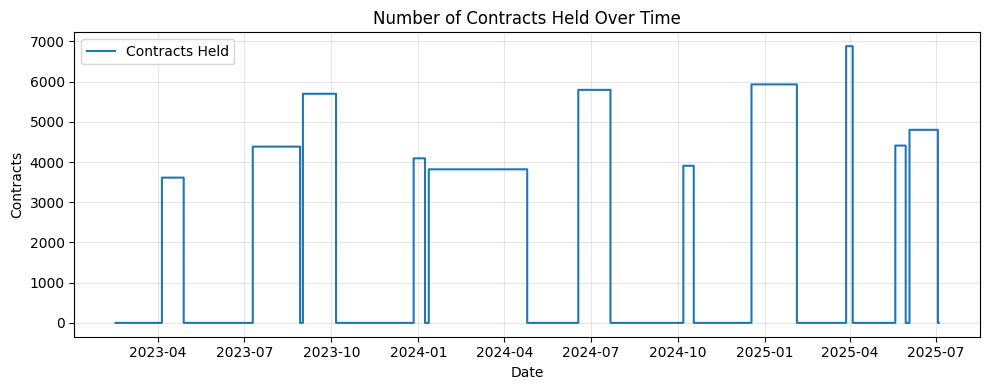

In [ ]:
def reconstruct_contracts_from_trades(price_series: pd.Series,
                                      trades_df: pd.DataFrame) -> pd.Series:
    """
    Builds a time series of contracts held (volume) from trade history.
    Positive = long, 0 = flat (we only have long trades in the Strategy).
    """
    price = price_series.copy().sort_index()
    contracts = pd.Series(index=price.index, dtype=float)

    open_pos = None
    closes_by_date, opens_by_date = {}, {}

    if trades_df is not None and not trades_df.empty:
        for _, row in trades_df.iterrows():
            od = pd.to_datetime(row["open_datetime"])
            opens_by_date.setdefault(od, []).append(row)
            if pd.notna(row.get("close_datetime")):
                cd = pd.to_datetime(row["close_datetime"])
                closes_by_date.setdefault(cd, []).append(row)

    for ts, _ in price.items():
        # check closes
        if ts in closes_by_date and open_pos is not None:
            open_pos = None

        # check opens
        if ts in opens_by_date and open_pos is None:
            row = opens_by_date[ts][-1]
            open_pos = {"vol": int(row["volume"])}

        contracts.loc[ts] = open_pos["vol"] if open_pos is not None else 0

    return contracts.ffill()

contracts_series = reconstruct_contracts_from_trades(df_sma["price"], trades_df)

plt.figure(figsize=(10, 4))
plt.plot(contracts_series.index, contracts_series.values, drawstyle="steps-post", label="Contracts Held")
plt.title("Number of Contracts Held Over Time")
plt.xlabel("Date")
plt.ylabel("Contracts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



## **MACD**

In [ ]:
start_date ='2023-01-01' # same as start of  test period in evaluation section of RL agents
#df_MACD : dataframe to be used for MACD strategy
df_MACD = df[df['Date'] >= start_date].copy()

df_MACD["Date"] = pd.to_datetime(df_MACD["Date"])
df_MACD = df_MACD.sort_values("Date").set_index("Date")
# Calculating Short-term EMA (12 periods)
ema_fast = df_MACD['price'].ewm(span=12, adjust=False).mean()

# Calculate the Long-term EMA (26 periods)
ema_slow = df_MACD['price'].ewm(span=26, adjust=False).mean()

# MACD, Signal, Histogram
macd_line = ema_fast - ema_slow
signal_line = macd_line.ewm(span=9, adjust=False).mean()
macd_histogram = macd_line - signal_line

# Add MACD components to the DataFrame
df_MACD['MACD_Line'] = macd_line
df_MACD['Signal_Line'] = signal_line
df_MACD['MACD_Histogram'] = macd_histogram

# Crossovers (MACD vs Signal)
diff_prev = (macd_line - signal_line).shift(1)
diff_now  = (macd_line - signal_line)

bullish = (diff_prev <= 0) & (diff_now > 0)
bearish = (diff_prev >= 0) & (diff_now < 0)

df_MACD["crossover"] = None
df_MACD.loc[bullish, "crossover"] = "bullish crossover"
df_MACD.loc[bearish, "crossover"] = "bearish crossover"


# Display MACD values
df_MACD

,price,High,Low,Open,Volume,MACD_Line,Signal_Line,MACD_Histogram,crossover
Date,,,,,,,,,
2023-01-03,82.099998,87.019997,81.769997,86.040001,27559,0.000000,0.000000,0.000000,None
2023-01-04,77.839996,82.669998,77.720001,82.230003,24772,-0.339829,-0.067966,-0.271863,bearish crossover
2023-01-05,78.690002,79.959999,77.610001,78.089996,28051,-0.534398,-0.161252,-0.373146,None
2023-01-06,78.570000,80.570000,78.050003,78.809998,23767,-0.690320,-0.267066,-0.423254,None
2023-01-09,79.650002,81.370003,78.339996,78.480003,29985,-0.718461,-0.357345,-0.361116,None
...,...,...,...,...,...,...,...,...,...
2025-06-30,67.610001,68.120003,67.110001,67.169998,32957,0.726971,1.373079,-0.646109,None
2025-07-01,67.110001,67.480003,66.339996,66.589996,29256,0.487504,1.195964,-0.708460,None
2025-07-02,69.110001,69.199997,66.940002,67.209999,50268,0.453876,1.047547,-0.593670,None


In [ ]:
# MACD Crossover strategy using ATR-Based Position Sizing & Stops
# To know more about these classes please refer to the thesis section related to SMA-Crossover simulation
# ATR
ATR_WINDOW = 14  #  norm is 14 days

df_MACD["prev_close"] = df_MACD["price"].shift(1)
# True Range components based on Wilder,1978, Van Tharp and Alexander Elder
tr_1 = df_MACD["High"] - df_MACD["Low"]
tr_2 = (df_MACD["High"] - df_MACD["prev_close"]).abs()
tr_3 = (df_MACD["Low"] - df_MACD["prev_close"]).abs()

# TR = max of intraday range and gap ranges
df_MACD["true_range"] = pd.concat([tr_1, tr_2, tr_3], axis=1).max(axis=1)

# Pandas EWM with adjust=False uses y_t​=αx_tt​+(1−α)y_{t−1} ​, if we set a=1/n and take x_t=TR_t we reach the same formula we have in the thesis:
# TRt=  ((n-1) 〖ATR〗_(t-1)+〖TR〗_t)/n
df_MACD["ATR"] = df_MACD["true_range"].ewm(alpha=1/ATR_WINDOW, adjust=False).mean()

# droping initialisation rows so ATR is defined
df_MACD = df_MACD.dropna(subset=["ATR"])


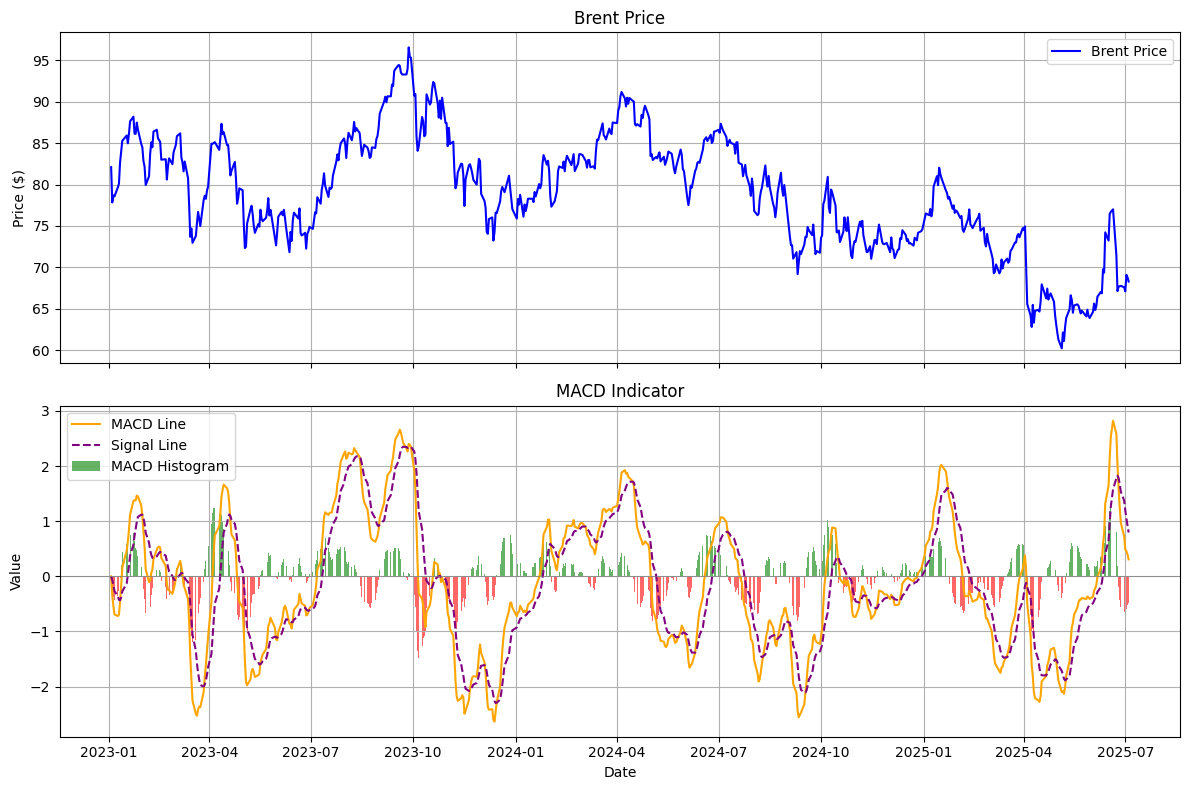

In [ ]:
# Create a figure and a set of subplots
# We need 2 subplots: one for price, one for MACD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True) # sharex=True links the x-axis

# Plot 1: Price Data
ax1.plot(df_MACD.index, df_MACD['price'], label='Brent Price', color='blue')
ax1.set_title('Brent Price')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid()

# Plot 2: MACD Data
ax2.plot(df_MACD.index, df_MACD['MACD_Line'], label='MACD Line', color='orange')
ax2.plot(df_MACD.index, df_MACD['Signal_Line'], label='Signal Line', color='purple', linestyle='--')
# Plot the histogram as a bar chart
ax2.bar(df_MACD.index, df_MACD['MACD_Histogram'], label='MACD Histogram', color=df_MACD['MACD_Histogram'].apply(lambda x: 'g' if x >= 0 else 'r'), alpha=0.6)

ax2.set_title('MACD Indicator')
ax2.set_ylabel('Value')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True)
ax2.axhline(0, color='grey', linestyle='-', linewidth=0.5) # Add zero line for reference

# Improve layout and display the plot
plt.tight_layout()
plt.show()

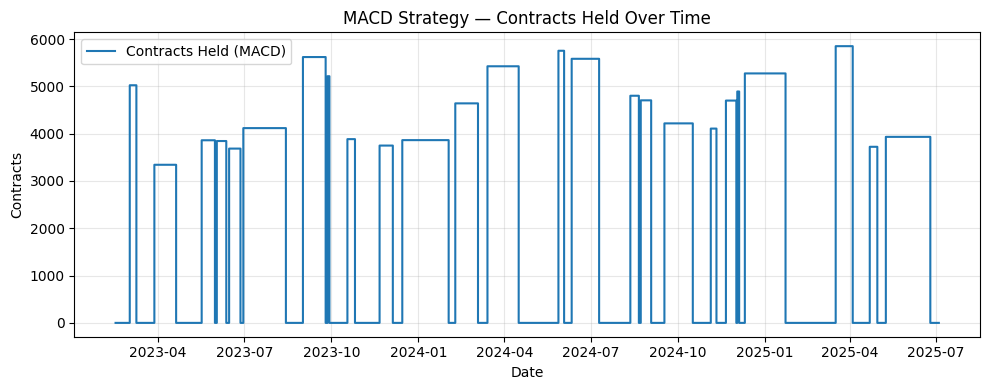

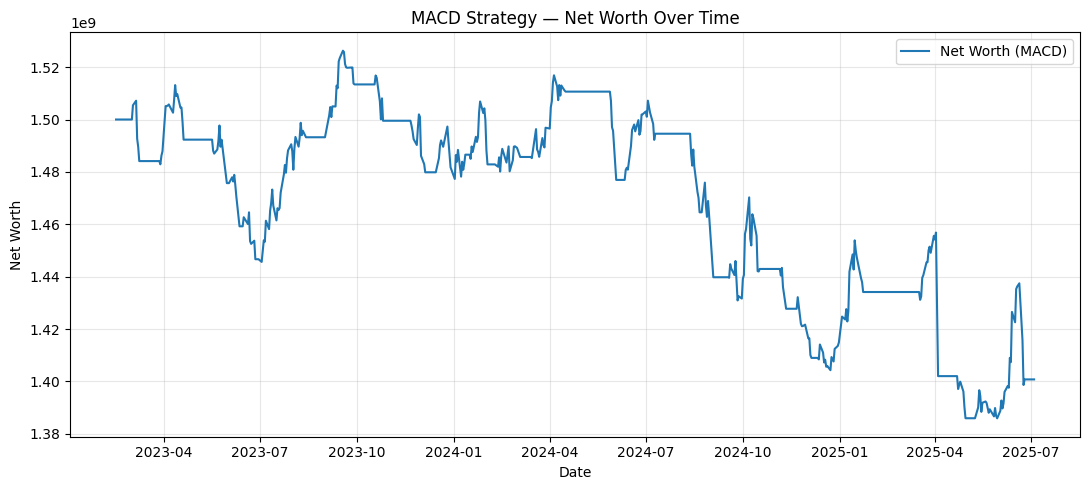

In [ ]:
# MACD crossover + ATR sizing/stops: plots for contracts and net worth

#  helper from earlier (reuse them as-is)
def reconstruct_contracts_from_trades(price: pd.Series, trades: pd.DataFrame) -> pd.Series:
    """Return a Series (same DateTime index as `price`) with contracts held (>=0)."""
    idx = price.sort_index().index
    contracts = pd.Series(0.0, index=idx)
    if trades is None or trades.empty:
        return contracts
    for _, t in trades.iterrows():
        od = pd.to_datetime(t["open_datetime"])
        cd = pd.to_datetime(t["close_datetime"]) if "close_datetime" in t and pd.notna(t["close_datetime"]) else None
        vol = float(t.get("volume", 0))
        start = idx.searchsorted(od)                         # inclusive
        stop  = idx.searchsorted(cd) if cd is not None else len(idx)  # exclusive
        if start < len(idx):
            contracts.iloc[start:stop] = vol
    return contracts

def add_macd_crossover(df: pd.DataFrame, fast=12, slow=26, signal=9, price_col="price") -> pd.DataFrame:
    out = df.copy()
    ema_fast = out[price_col].ewm(span=fast, adjust=False).mean()
    ema_slow = out[price_col].ewm(span=slow, adjust=False).mean()
    out["MACD_Line"] = ema_fast - ema_slow
    out["Signal_Line"] = out["MACD_Line"].ewm(span=signal, adjust=False).mean()
    above = out["MACD_Line"] > out["Signal_Line"]
    out["crossover"] = None
    out.loc[ above & ~above.shift(1, fill_value=False), "crossover"] = "bullish crossover"
    out.loc[~above &  above.shift(1, fill_value=False), "crossover"] = "bearish crossover"
    return out

    for ts, _ in price.items():
        # close any open position if a close lands on ts
        if ts in closes_by_date and open_pos is not None:
            open_pos = None
        # open if we have an open event and currently flat
        if ts in opens_by_date and open_pos is None:
            row = opens_by_date[ts][-1]
            open_pos = {"vol": int(row["volume"])}
        contracts.loc[ts] = open_pos["vol"] if open_pos is not None else 0

    return contracts.ffill()

#  Build MACD crossover dataframe (uses the 'ATR' already computed on df_CO)
macd_df = add_macd_crossover(df_CO, fast=12, slow=26, signal=9)

# ensure DateTime index
if "Date" in macd_df.columns:
    macd_df["Date"] = pd.to_datetime(macd_df["Date"])
    macd_df = macd_df.set_index("Date").sort_index()
else:
    macd_df = macd_df.sort_index()
    if not isinstance(macd_df.index, pd.DatetimeIndex):
        macd_df.index = pd.to_datetime(macd_df.index)

# ensure Low exists for stop logic
if "Low" not in macd_df.columns:
    macd_df["Low"] = macd_df["price"]

#  run strategy for MACD
sizer = ATRRiskSizer(risk_pct=0.02, k_atr=3.0, contract_mult=1000.0, lot_size=1)
starting_balance = 1.5e9
contract_mult = 1000.0

strat_macd = Strategy(
    df=macd_df,                     # expects columns: price, ATR, Low, crossover
    starting_balance=starting_balance,
    position_sizer=sizer,
    one_at_a_time=True,
    use_atr_stop=True,
    stop_k_atr=3.0,
    contract_mult=contract_mult)
macd_trades = strat_macd.run(force_close_end=True)

#  building time series for Net Worth and Contracts
macd_nw = reconstruct_net_worth_from_trades(macd_df["price"], macd_trades, starting_balance, contract_mult)
macd_contracts = reconstruct_contracts_from_trades(macd_df["price"], macd_trades)

#  Plotting contracts held over time (step plot)

plt.figure(figsize=(10, 4))
plt.plot(macd_contracts.index, macd_contracts.values, drawstyle="steps-post", label="Contracts Held (MACD)")
plt.title("MACD Strategy — Contracts Held Over Time")
plt.xlabel("Date")
plt.ylabel("Contracts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 4))
plt.plot(macd_nw.index, macd_nw.values, label="Net Worth (MACD)", color="tab:blue")
plt.title("MACD Strategy — Net Worth Over Time")
plt.xlabel("Date")
plt.ylabel("Net Worth")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# **Reinforcement learning**

In [ ]:
# this section calculates the features (10) as it was explained in the thesis

def compute_indicators(df):
    out = df.copy()
    #returns
    out["Return"] = out["price"].pct_change()
    out['r_1m'] = out['price'].pct_change(21)
    out['r_2m'] = out['price'].pct_change(42)
    out['r_3m'] = out['price'].pct_change(63)
    out['r_1y'] = out['price'].pct_change(252)

    # RSI
    '''from Zihao Zhang et al, 2020 : The RSI is an oscillating indicator moving between 0 and 100.
        It indicates the oversold (a reading below 20) or overbought (above 80) conditions of an asset
        by measuring the magnitude of recent price changes. We include this indicator with a look back
        window of 30 days in our state representations.'''
    delta = out["price"].diff()
    up = delta.clip(lower=0).rolling(30).mean()
    down = -delta.clip(upper=0).rolling(30).mean()
    rs = up / (down + 1e-12)         # prevent division by zero
    out["RSI"] = 100 - (100 / (1 + rs))

    # Volatility
    out['volatility'] = out['Return'].ewm(span=60).std()
    '''Exponentially weighted standard deviation.Weighting: Recent returns get more weight, older returns
     decay exponentially.want volatility to adapt quickly to new market conditions'''


    # high-low diff
    out["HL_diff"] = out["High"] - out["Low"]

    #ATR (Wilder's smoothing of True Range)
    out['prev_close'] = out['price'].shift(1)
    tr1 = out['High'] - out['Low']
    tr2 = (out['High'] - out['prev_close']).abs()
    tr3 = (out['Low']  - out['prev_close']).abs()
    out['true_range'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    ATR_WINDOW = 14
    # Wilder's ATR via EWM with alpha=1/n and adjust=False:
    out['ATR'] = out['true_range'].ewm(alpha=1/ATR_WINDOW, adjust=False).mean()
    #############

    #out.drop(columns = ['High', 'Low', 'Open','Volume'], inplace=True)
    out.drop(columns = ['High', 'Low', 'Open'], inplace=True)

    out = out.dropna()
    return out

feat = compute_indicators(df)
display(feat.head(3))


,Date,price,Volume,Return,r_1m,r_2m,r_3m,r_1y,RSI,volatility,HL_diff,prev_close,true_range,ATR
844,2011-01-05,95.500000,1265,0.021063,0.044287,0.085227,0.122737,0.191962,72.399095,0.013185,3.279999,93.529999,3.279999,1.681015
845,2011-01-06,94.519997,1439,-0.010262,0.034249,0.072750,0.132926,0.172850,71.648112,0.013173,1.989998,95.500000,1.989998,1.703085
846,2011-01-07,93.330002,772,-0.012590,0.028203,0.055053,0.110675,0.139700,65.205061,0.013226,1.879997,94.519997,1.879997,1.715722


# **Trading Environment**

In [ ]:
import gymnasium as gym
from gymnasium import spaces
from sklearn.preprocessing import StandardScaler

class TradingEnv(gym.Env):
    def __init__(
        self,
        df,
        lookback_window=20,
        transaction_cost=3e-5,   # fraction of notional per side
        scaler=None,
        # ATR risk-per-trade sizing params
        risk_pct=0.02,
        atr_lookback=14,
        k_atr=3.0,
        atr_floor=1e-8,
        contract_mult=1000.0,    # standard CL/Brent = 1000 bbl/contract
        lot_size=1,              # Cmake this an int by default
        use_atr_stop=True,
        sell_all_on_action=True
    ):
        super().__init__()
        self.df = df.copy()

        self.price_raw = self.df['price'].to_numpy(dtype=float)  # $/bbl


        # Features to normalize (exclude raw execution price)
        num_cols = self.df.select_dtypes(include=np.number).columns
        self.feature_columns = [c for c in num_cols if c not in ('price', )]

        self.scaler = scaler or StandardScaler()
        self._normalize_data()

        # pre-extract numpy arrays for fast runtime
        self.X = self.df[self.feature_columns].to_numpy(dtype=np.float32)
        self.low_arr = self.df['Low'].to_numpy(dtype=np.float32) if 'Low' in self.df.columns else None
        self.atr_arr = self.df['ATR'].to_numpy(dtype=np.float32)

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(lookback_window * len(self.feature_columns),),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)
        self.lookback_window = int(lookback_window)
        self.transaction_cost = float(transaction_cost)

        # ATR sizing config
        self.risk_pct = float(risk_pct)
        self.atr_lookback = int(atr_lookback)
        self.k_atr = float(k_atr)
        self.atr_floor = float(atr_floor)
        self.contract_mult = float(contract_mult)  # bbl per contract
        self.lot_size = int(lot_size)
        self.use_atr_stop = bool(use_atr_stop)
        self.sell_all_on_action = bool(sell_all_on_action)

    def _normalize_data(self):
        if hasattr(self.scaler, "mean_") or hasattr(self.scaler, "scale_"):
            self.df[self.feature_columns] = self.scaler.transform(self.df[self.feature_columns])
        else:
            self.df[self.feature_columns] = self.scaler.fit_transform(self.df[self.feature_columns])

    # use precomputed numpy features to run faster
    def _get_observation(self):
        i0 = self.current_step - self.lookback_window
        i1 = self.current_step
        return self.X[i0:i1].reshape(-1)  # already float32 numpy

    def _atr_eff(self):
        return float(max(self.atr_arr[self.current_step - 1], self.atr_floor))

    def _max_units_allowed(self, equity):
        # ATR is $/bbl; risk per contract includes contract_mult
        per_unit_risk = self.k_atr * self._atr_eff() * self.contract_mult
        if per_unit_risk <= 0 or equity <= 0:
            return 0
        return int((self.risk_pct * equity) // per_unit_risk)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = max(self.lookback_window, self.atr_lookback + 1)
        self.balance = 1.5e9
        self.shares_held = 0            # contracts
        self.net_worth = self.balance
        self.entry_price = None         # $/bbl
        self.stop_price = None          # $/bbl

        self.history = {
            'Date': [], 'Price': [], 'NetWorth': [], 'Action': [],
            'Position': [], 'ATR': [], 'Stop': [], 'UnitsBuy': [], 'UnitsSell': []
        }
        return self._get_observation(), {}

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.df):
            return self._get_observation(), 0.0, True, False, {}

        price = float(self.price_raw[self.current_step])  # $/bbl
        buy_px  = price
        sell_px = price

        # Enforce ATR stop before taking the action
        if self.use_atr_stop and self.shares_held > 0 and self.stop_price is not None:
            low_px = float(self.low_arr[self.current_step]) if self.low_arr is not None else price
            if low_px <= self.stop_price:
                # conservative fill for longs = lower of stop vs current
                fill_px = min(self.stop_price, sell_px)
                # include contract_mult in notional and fee
                notional = self.shares_held * fill_px * self.contract_mult
                fee = notional * self.transaction_cost
                self.balance += (notional - fee)
                self.shares_held = 0
                self.entry_price = None
                self.stop_price = None

        # equity must include contract_mult
        equity = self.balance + self.shares_held * price * self.contract_mult
        max_units = self._max_units_allowed(equity)

        units_bought = 0
        units_sold = 0

        if action == 1:  # BUY
            addable = max(0, max_units - self.shares_held)
            # per-contract cash cost uses contract_mult
            total_cost_per_unit = buy_px * self.contract_mult * (1.0 + self.transaction_cost)
            max_afford = int(self.balance // total_cost_per_unit)
            qty = max(0, min(addable, max_afford))
            qty = (qty // self.lot_size) * self.lot_size
            if qty > 0:
                # notional & fee with contract_mult
                notional = qty * buy_px * self.contract_mult
                fee = notional * self.transaction_cost
                self.shares_held += qty
                self.balance -= (notional + fee)
                units_bought = qty
                if self.use_atr_stop:
                    # entry_price still in $/bbl (volume-weighted)
                    self.entry_price = buy_px if self.entry_price is None else (
                        (self.entry_price * (self.shares_held - qty) + buy_px * qty) / self.shares_held
                    )
                    self.stop_price = self.entry_price - self.k_atr * self._atr_eff()

        elif action == 2 and self.shares_held > 0:  # SELL
            qty = self.shares_held if self.sell_all_on_action else max(1, self.shares_held // 2)
            qty = (qty // self.lot_size) * self.lot_size
            if qty > 0:
                # notional & fee with contract_mult
                notional = qty * sell_px * self.contract_mult
                fee = notional * self.transaction_cost
                self.balance += (notional - fee)
                self.shares_held -= qty
                units_sold = qty
                if self.shares_held == 0:
                    self.entry_price = None
                    self.stop_price = None

        prev_net = self.net_worth
        #  net worth must include contract_mult
        self.net_worth = self.balance + self.shares_held * price * self.contract_mult
        step_ret = (self.net_worth - prev_net) / max(prev_net, 1e-12)
        reward = float(np.clip(step_ret, -1.0, 1.0))

        done = self.current_step >= len(self.df) - 1

        self.history['Date'].append(self.df['Date'].iloc[self.current_step] if 'Date' in self.df.columns else self.current_step)
        self.history['Price'].append(price)
        self.history['NetWorth'].append(self.net_worth)
        self.history['Action'].append(int(action))
        self.history['Position'].append(int(self.shares_held))
        self.history['ATR'].append(float(self._atr_eff()))
        self.history['Stop'].append(float(self.stop_price) if self.stop_price is not None else np.nan)
        self.history['UnitsBuy'].append(int(units_bought))
        self.history['UnitsSell'].append(int(units_sold))

        return self._get_observation(), reward, bool(done), False, {}


#  DQN and PG Agents
Here, we define NNs and training loops for each agent and evaluate their performance.

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

class PGPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PGPolicy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.fc(x)

# PG with entropy regularization and annealing:
def agent_pg(env, episodes=200, gamma=0.99, entropy_beta_start=0.02, entropy_beta_end=0.0, lr=1e-4, max_steps_per_episode=None):
    """
    Policy Gradient with entropy bonus to encourage exploration early.
    Assumes a PGPolicy network PGPolicy(input_dim, output_dim) that returns probs via softmax.
    """
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    policy = PGPolicy(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    episode_rewards = []

    for ep in range(episodes):
        beta = max(entropy_beta_end, entropy_beta_start * (1 - ep/episodes))

        state, _ = env.reset()
        done = False
        log_probs, rewards, entropies = [], [], []
        total_reward = 0.0
        steps = 0

        while not done:
            st = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            probs = policy(st)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            entropies.append(dist.entropy())

            next_state, reward, done, truncated, _ = env.step(int(action.item()))
            rewards.append(float(reward))
            state = next_state
            total_reward += float(reward)

            steps += 1
            if max_steps_per_episode is not None and steps >= max_steps_per_episode:
                break

        # returns
        G, returns = 0.0, []
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        if returns.numel() > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        policy_loss = []
        for lp, R, H in zip(log_probs, returns, entropies):
            policy_loss.append(-lp * R - beta * H)
        loss = torch.stack(policy_loss).sum()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.0)
        optimizer.step()

        episode_rewards.append(float(total_reward))
    return policy, episode_rewards


# in DQN we also added exploration–exploitation for DQN:
def agent_dqn(env, episodes=200, gamma=0.99, batch_size=64,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay_steps=50_000,
              lr=1e-4, tau=0.005, replay_size=50_000, max_steps_per_episode=None):
    """
    DQN with:
      - Per-step exponential epsilon decay, Double-DQN targets, Soft target updates (tau)
      and Gradient clipping"""
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=replay_size)
    rewards = []

    step_count = 0

    def select_action(state):
        nonlocal step_count
        step_count += 1
        eps = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-step_count / epsilon_decay_steps)
        if random.random() < eps:
            return random.randrange(output_dim)
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            return int(policy_net(s).argmax().item())

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0.0
        steps = 0

        while not done:
            action = select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            ep_reward += float(reward)

            if len(memory) >= batch_size:
                s, a, r, s_, d = zip(*random.sample(memory, batch_size))
                s   = torch.tensor(np.vstack(s),  dtype=torch.float32)
                a   = torch.tensor(a,dtype=torch.long)
                r   = torch.tensor(r,dtype=torch.float32)
                s_  = torch.tensor(np.vstack(s_),dtype=torch.float32)
                d   = torch.tensor(d,dtype=torch.float32)

                # Double DQN target (overstimation prevented):
                with torch.no_grad():
                    next_actions = policy_net(s_).argmax(1)                 # argmax under online net
                    q_next = target_net(s_).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    target = r + gamma * q_next * (1 - d)

                q = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
                loss = F.mse_loss(q, target)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
                optimizer.step()

                # Soft target update
                with torch.no_grad():
                    for p, tp in zip(policy_net.parameters(), target_net.parameters()):
                        tp.data.mul_(1 - tau).add_(tau * p.data)

            steps += 1
            if max_steps_per_episode is not None and steps >= max_steps_per_episode:
                break

        rewards.append(float(ep_reward))

    return policy_net, rewards

# **Train and Evaluate Agents**

In [ ]:
# Split data into training and testing (2010–2025)
df = feat[feat['Date'] >= '2010-01-01']
train_df = feat[feat['Date'] < '2023-01-01'] # training set for RL algs
test_df = feat[feat['Date'] >= '2023-01-01'] # testing data set for RL alg
# Create environments
train_env = TradingEnv(train_df.copy())
test_env = TradingEnv(test_df.copy(), scaler=train_env.scaler)  # share scaler

## **Train RL Models**

In [ ]:
# Train DQN model on train_env
dqn_model, dqn_rewards_train = agent_dqn(train_env, episodes=1000)

In [ ]:
# Train PG model on train_env
pg_model, pg_rewards_train = agent_pg(train_env, episodes=1000)

# **Test RL Models**

In [ ]:
def test_agent(env, model, agent_type='dqn', greedy=True, device=None): # devide cpu, cuda, mps, where the PyTorch model runs
    """ Runs ONE full episode on env with a trained model.
    Returns:
      total_reward_sum : sum of (training) step rewards (clipped in env)
      history_df       : DataFrame built from env.history (use this for real metrics)"""
    device = device or next(model.parameters()).device
    model.eval()

    state, _ = env.reset()
    step_rewards = []
    terminated = truncated = False

    with torch.no_grad():
        while not (terminated or truncated):
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            if agent_type == 'dqn':
                q = model(st)                               # (1, n_actions)
                action = int(q.argmax(dim=1).item())
            elif agent_type == 'pg':
                probs = model(st)                           # (1, n_actions)
                if greedy:
                    action = int(probs.argmax(dim=1).item())
                else:
                    dist = torch.distributions.Categorical(probs)
                    action = int(dist.sample().item())
            else:
                raise ValueError(f"Unknown agent_type: {agent_type}")

            next_state, reward, terminated, truncated, _ = env.step(action)
            step_rewards.append(float(reward))
            state = next_state

    history = getattr(env, 'history', None)
    hist_df = pd.DataFrame(history) if isinstance(history, dict) else pd.DataFrame()

    return float(np.sum(step_rewards)), hist_df


In [ ]:
dqn_reward, dqn_hist_test = test_agent(test_env, dqn_model, agent_type='dqn', greedy=True)
pg_reward,  pg_hist_test  = test_agent(test_env, pg_model,  agent_type='pg',  greedy=True)

# Metrics function

In [ ]:
def summarize_performance(hist_df_or_series, periods_per_year: int = 252, rf_annual: float = 0.04):
    """Compute performance metrics from NetWorth time series. Accepts either:
      - pd.DataFrame with columns ['Date', 'NetWorth'], or
      - pd.Series of NetWorth indexed by datetime.
    Parameters:
              hist_df_or_series: pd.DataFrame or pd.Series
              periods_per_yea: int
              Trading periods per year (252 for daily, 52 for weekly, etc.)
    rf_annual: float
              Annual risk-free rate (e.g., SONIA/T-bill). Set 0.0 to ignore.
    Returns:
            dict{"Cumulative Return", "CAGR", "Sharpe (ann.)", "Sortino (ann.)",
           "Calmar", "Volatility (ann.)", "Max Drawdown", "Last NetWorth"} """
    # Build netWorth series
    if isinstance(hist_df_or_series, pd.Series):
        nw = hist_df_or_series.copy()
    elif isinstance(hist_df_or_series, pd.DataFrame) and {"Date", "NetWorth"}.issubset(hist_df_or_series.columns):
        nw = pd.Series(hist_df_or_series["NetWorth"].values,
                       index=pd.to_datetime(hist_df_or_series["Date"]))
    else:
        raise ValueError("Expected a NetWorth Series (datetime index) OR a DataFrame with ['Date','NetWorth'].")

    nw = nw.sort_index().astype(float).dropna()
    # Guard against too-short series, make the nan
    if nw.size < 2:
        last = float(nw.iloc[-1]) if nw.size else np.nan
        return { "Cumulative Return": np.nan, "CAGR": np.nan, "Sharpe (ann.)": np.nan,
            "Sortino (ann.)": np.nan, "Calmar": np.nan, "Volatility (ann.)": np.nan,
            "Max Drawdown": np.nan, "Last NetWorth": last }

    #  Returns & equity curve
    ret = nw.pct_change().dropna()
    equity = (1.0 + ret).cumprod()
    cumret = float(equity.iloc[-1] - 1.0)

    #  Risk-free handling (convert annual to per-period)
    rf_p = (1.0 + rf_annual) ** (1.0 / periods_per_year) - 1.0 if rf_annual else 0.0
    excess = ret - rf_p

    # Sharpe / Sortino
    mu = excess.mean()
    sigma = excess.std(ddof=1)
    sharpe = np.sqrt(periods_per_year) * (mu / sigma) if sigma > 0 else np.nan

    downside = ret[ret < 0].std(ddof=1)
    sortino = np.sqrt(periods_per_year) * (mu / downside) if downside > 0 else np.nan

    #  Drawdown metrics
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    maxdd = float(dd.min())  # negative number

    #  CAGR
    # Use calendar time to avoid bias from missing days, we can work based on 252 trading days as well, I decided to use this:
    n_years = (equity.index[-1] - equity.index[0]).days / 365.25
    cagr = (nw.iloc[-1] / nw.iloc[0]) ** (1.0 / n_years) - 1.0 if n_years > 0 else np.nan

    # Calmar
    calmar = (cagr / abs(maxdd)) if (maxdd < 0) else np.nan

    # Annulized volatility (of raw returns)
    vol_ann = float(np.sqrt(periods_per_year) * ret.std(ddof=1))

    return {"Cumulative Return": float(cumret),
             "CAGR": float(cagr),
             "Sharpe (ann.)": float(sharpe),
             "Sortino (ann.)": float(sortino),
              "Calmar": float(calmar),
              "Volatility (ann.)": vol_ann,
               "Max Drawdown": float(maxdd),
              "Last NetWorth": float(nw.iloc[-1])}


# **Visualization of results-1**

/tmp/ipython-input-153689168.py:8: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-153689168.py:23: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



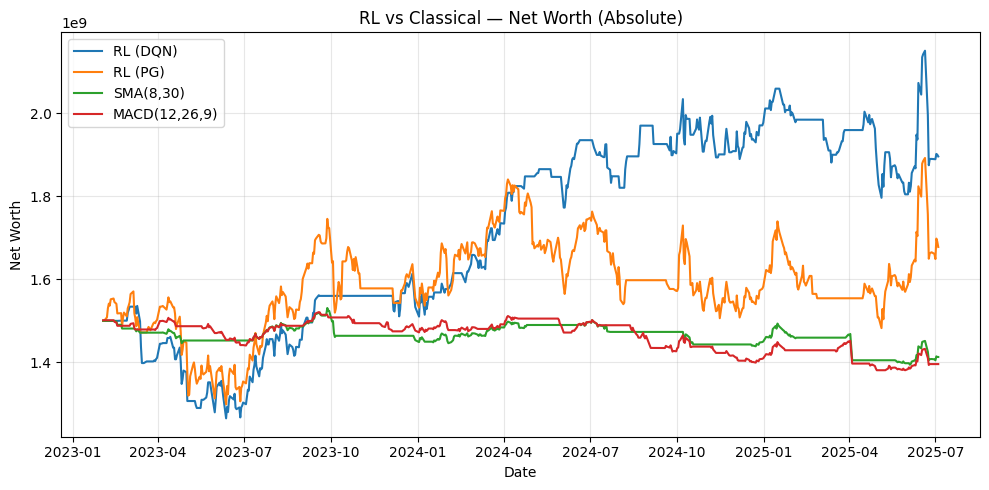

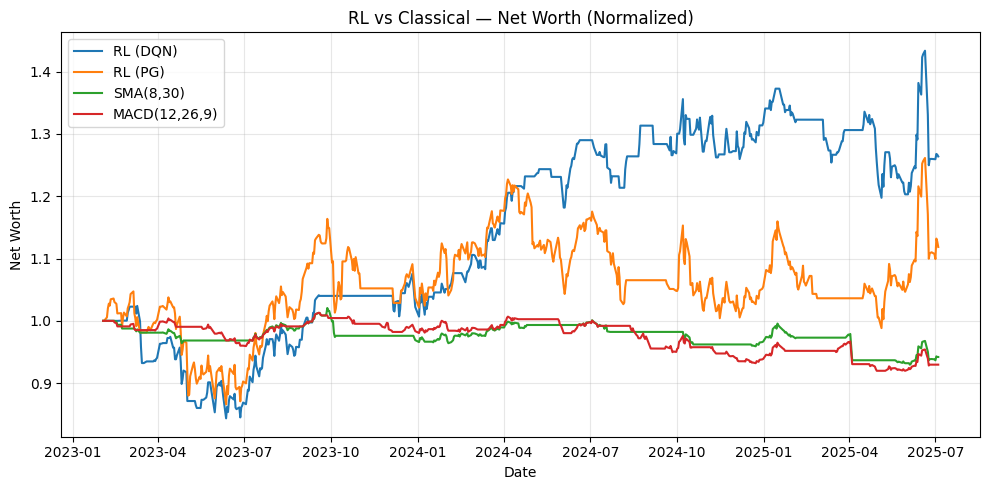

,Cumulative Return,CAGR,Sharpe (ann.),Sortino (ann.),Calmar,Volatility (ann.),Max Drawdown,Last NetWorth
RL (DQN),0.2638,0.1018,0.3724,0.3842,0.5779,0.1921,-0.1762,1.895661e+09
RL (PG),0.1185,0.0475,0.1297,0.1625,0.2443,0.2387,-0.1944,1.677821e+09
"SMA(8,30)",-0.0580,-0.0244,-1.4383,-1.0678,-0.2739,0.0470,-0.0892,1.413048e+09
"MACD(12,26,9)",-0.0702,-0.0297,-1.4818,-1.4204,-0.3231,0.0493,-0.0920,1.395985e+09


In [ ]:
# ### Build classical signals (crossover column)

def add_sma_crossover(df: pd.DataFrame, fast: int = 10, slow: int = 30, price_col: str = "price") -> pd.DataFrame:
    out = df.copy()
    out["SMA_fast"] = out[price_col].rolling(fast, min_periods=fast).mean()
    out["SMA_slow"] = out[price_col].rolling(slow, min_periods=slow).mean()
    above = out["SMA_fast"] > out["SMA_slow"]
    above_prev = above.shift(1).fillna(False)
    out["crossover"] = None
    out.loc[( above) & (~above_prev), "crossover"] = "bullish crossover"
    out.loc[(~above) & ( above_prev), "crossover"] = "bearish crossover"
    return out

def add_macd_crossover(df: pd.DataFrame, fast: int = 12, slow: int = 26, signal: int = 9, price_col: str = "price") -> pd.DataFrame:
    out = df.copy()
    if not {"MACD_Line", "Signal_Line"}.issubset(out.columns):
        ema_fast = out[price_col].ewm(span=fast, adjust=False).mean()
        ema_slow = out[price_col].ewm(span=slow, adjust=False).mean()
        out["MACD_Line"] = ema_fast - ema_slow
        out["Signal_Line"] = out["MACD_Line"].ewm(span=signal, adjust=False).mean()
    macd = out["MACD_Line"]; sig = out["Signal_Line"]
    above = macd > sig
    above_prev = above.shift(1).fillna(False)
    out["crossover"] = None
    out.loc[( above) & (~above_prev), "crossover"] = "bullish crossover"
    out.loc[(~above) & ( above_prev), "crossover"] = "bearish crossover"
    return out


# ### Run Strategy and reconstruct the NET_WORTH (not returns)
def run_classical_strategy(
    df: pd.DataFrame,
    starting_balance: float = 1.5e9,
    sizer=None,
    one_at_a_time: bool = True,
    use_atr_stop: bool = True,
    stop_k_atr: float = 3.0,
    contract_mult: float = 1000.0):
    # Ensure a DateTime index
    out = df.copy()
    if "Date" in out.columns:
        out["Date"] = pd.to_datetime(out["Date"])
        out = out.set_index("Date").sort_index()
    else:
        out = out.sort_index()
        if not isinstance(out.index, pd.DatetimeIndex):
            out.index = pd.to_datetime(out.index)

    if use_atr_stop and "ATR" not in out.columns:
        raise ValueError("DataFrame must include 'ATR' to use ATR stops.")
    if use_atr_stop and "Low" not in out.columns:
        out["Low"] = out["price"]

    strat = Strategy(
        df=out,
        starting_balance=starting_balance,
        volume=None,
        position_sizer=sizer,
        one_at_a_time=one_at_a_time,
        use_atr_stop=use_atr_stop,
        stop_k_atr=stop_k_atr,
        contract_mult=contract_mult )
    trades_df = strat.run(force_close_end=True)

    # Net worth time series (realized + unrealized)
    net_worth = reconstruct_equity_from_trades(out["price"], trades_df, starting_balance, contract_mult)
    return trades_df, net_worth


def reconstruct_equity_from_trades(
    price_series: pd.Series,
    trades_df: pd.DataFrame,
    starting_balance: float,
    contract_mult: float = 1000.0
) -> pd.Series:
    price = price_series.copy().sort_index()
    nw = pd.Series(index=price.index, dtype=float)
    realized = 0.0
    open_pos = None  # {"open_px": float, "vol": int}

    closes_by_date, opens_by_date = {}, {}
    if not trades_df.empty:
        for _, row in trades_df.iterrows():
            od = pd.to_datetime(row["open_datetime"])
            opens_by_date.setdefault(od, []).append(row)
            if pd.notna(row.get("close_datetime")):
                cd = pd.to_datetime(row["close_datetime"])
                closes_by_date.setdefault(cd, []).append(row)

    for ts, px in price.items():
        if ts in closes_by_date and open_pos is not None:
            for row in closes_by_date[ts]:
                realized += (float(row["close_price"]) - open_pos["open_px"]) * open_pos["vol"] * contract_mult
                open_pos = None
        if ts in opens_by_date and open_pos is None:
            row = opens_by_date[ts][-1]
            open_pos = {"open_px": float(row["open_price"]), "vol": int(row["volume"])}
        unreal = (px - open_pos["open_px"]) * open_pos["vol"] * contract_mult if open_pos is not None else 0.0
        nw.loc[ts] = starting_balance + realized + unreal

    return nw.ffill()


# ### Build classical strategies (Net Worth only)
sizer = ATRRiskSizer(risk_pct=0.02, k_atr=3.0, contract_mult=1000.0, lot_size=1)

sma_df = add_sma_crossover(test_df, fast=8, slow=30)
sma_trades, sma_nw = run_classical_strategy(sma_df, starting_balance=1.5e9, sizer=sizer, stop_k_atr=3.0, contract_mult=1000.0)

macd_df = add_macd_crossover(test_df, fast=12, slow=26, signal=9)
macd_trades, macd_nw = run_classical_strategy(macd_df, starting_balance=1.5e9, sizer=sizer, stop_k_atr=3.0, contract_mult=1000.0)


# ### RL Net Worth from test_agent histories

dqn_nw = pd.Series(dqn_hist_test["NetWorth"].values, index=pd.to_datetime(dqn_hist_test["Date"]))
pg_nw  = pd.Series(pg_hist_test["NetWorth"].values,  index=pd.to_datetime(pg_hist_test["Date"]))


# ### Align & plot Net Worth for all four methodes

def plot_multi_net_worth(series_dict: dict, title: str = "RL vs Classical — Net Worth"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    for label, s in series_dict.items():
        plt.plot(s.index, s.values, label=label)
    plt.title(title); plt.xlabel("Date"); plt.ylabel("Net Worth")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

nw_common_idx = dqn_nw.index.intersection(pg_nw.index).intersection(sma_nw.index).intersection(macd_nw.index)
net_worth_series = { "RL (DQN)": dqn_nw.reindex(nw_common_idx).ffill(),
                     "RL (PG)"  : pg_nw.reindex(nw_common_idx).ffill(),
                      "SMA(8,30)": sma_nw.reindex(nw_common_idx).ffill(),
                      "MACD(12,26,9)" : macd_nw.reindex(nw_common_idx).ffill()}

plot_multi_net_worth(net_worth_series, title="RL vs Classical — Net Worth (Absolute)")

#  normalized to 1.0 at the start
norm_net_worth_series = {k: v / float(v.iloc[0]) for k, v in net_worth_series.items() if len(v) > 0}
plot_multi_net_worth(norm_net_worth_series, title="RL vs Classical — Net Worth (Normalized)")


# ### Performance table from NetWorth Series (no dicts of returns)

def summarize_performance(hist_df_or_series, periods_per_year: int = 252, rf_annual: float = 0.04):
    # Accept Series (NetWorth) or history DataFrame with Date/NetWorth
    if isinstance(hist_df_or_series, pd.Series):
        nw = hist_df_or_series.copy()
    elif isinstance(hist_df_or_series, pd.DataFrame) and {"Date","NetWorth"}.issubset(hist_df_or_series.columns):
        nw = pd.Series(hist_df_or_series["NetWorth"].values, index=pd.to_datetime(hist_df_or_series["Date"]))
    else:
        raise ValueError("Expected NetWorth Series or DataFrame with ['Date','NetWorth'].")

    nw = nw.sort_index().astype(float).dropna()
    if nw.size < 2:
        last = float(nw.iloc[-1]) if nw.size else np.nan
        return {"Cumulative Return": np.nan, "CAGR": np.nan, "Sharpe (ann.)": np.nan,
                "Sortino (ann.)": np.nan, "Calmar": np.nan, "Volatility (ann.)": np.nan,
                "Max Drawdown": np.nan, "Last NetWorth": last}

    ret = nw.pct_change().dropna()
    equity = (1 + ret).cumprod()
    cumret = float(equity.iloc[-1] - 1.0)

    rf_p = (1 + rf_annual) ** (1 / periods_per_year) - 1 if rf_annual else 0.0
    excess = ret - rf_p

    mu = excess.mean()
    sigma = excess.std(ddof=1)
    sharpe = np.sqrt(periods_per_year) * (mu / sigma) if sigma > 0 else np.nan

    downside = ret[ret < 0].std(ddof=1)
    sortino = np.sqrt(periods_per_year) * (mu / downside) if downside > 0 else np.nan

    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    maxdd = float(dd.min())

    n_years = (equity.index[-1] - equity.index[0]).days / 365.25
    cagr = (nw.iloc[-1] / nw.iloc[0]) ** (1 / n_years) - 1 if n_years > 0 else np.nan
    calmar = (cagr / abs(maxdd)) if (maxdd < 0) else np.nan
    vol_ann = float(np.sqrt(periods_per_year) * ret.std(ddof=1))

    return {"Cumulative Return": float(cumret), "CAGR": float(cagr),
            "Sharpe (ann.)": float(sharpe), "Sortino (ann.)": float(sortino),
            "Calmar": float(calmar), "Volatility (ann.)": vol_ann,
            "Max Drawdown": float(maxdd), "Last NetWorth": float(nw.iloc[-1])}

def summarize_performance_many(nw_dict: dict, periods_per_year: int = 252, rf_annual: float = 0.04) -> pd.DataFrame:
    rows = {name: summarize_performance(nw, periods_per_year, rf_annual) for name, nw in nw_dict.items()}
    return pd.DataFrame.from_dict(rows, orient="index")

perf_df = summarize_performance_many(net_worth_series, rf_annual=0.045)  # e.g., ~SONIA 4.5%
display(perf_df.round(4))


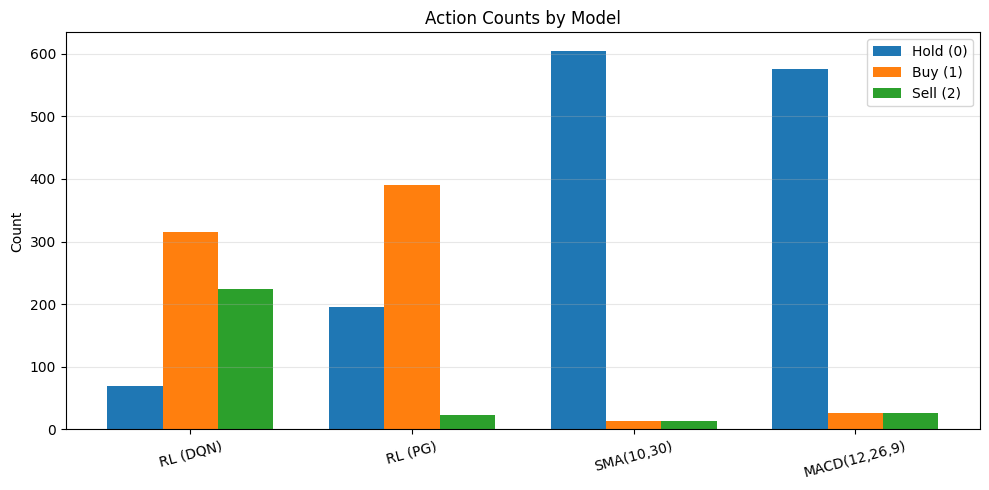

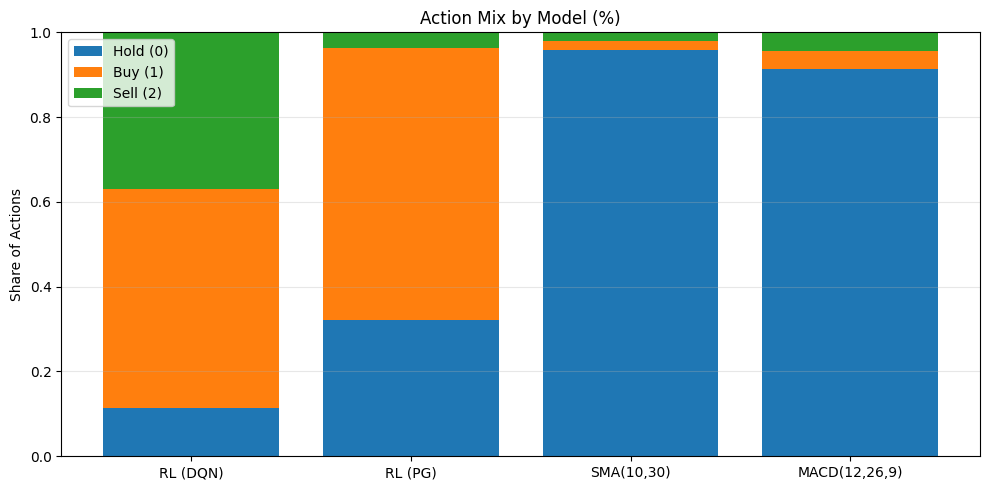

In [ ]:
# Actions: build series for RL and Classical

def get_action_series_rl(history_df: pd.DataFrame) -> pd.Series:
    """
    From test_agent history: expects columns ['Date','Action'] with 0/1/2.
    Returns a pd.Series indexed by datetime.
    """
    s = pd.Series(history_df["Action"].astype(int).values,
                  index=pd.to_datetime(history_df["Date"]))
    return s.sort_index()

def get_action_series_classical(trades_df: pd.DataFrame, index: pd.DatetimeIndex) -> pd.Series:
    """ Build an action series for classical strategies from trades:
      +1 at open_datetime, +2 at close_datetime, 0 elsewhere.
    Returns a pd.Series over the provided datetime index."""
    actions = pd.Series(0, index=index, dtype=int)  # default HOLD

    if trades_df is None or trades_df.empty:
        return actions

    # mark BUY on opens
    for _, row in trades_df.iterrows():
        od = pd.to_datetime(row["open_datetime"])
        # align to closest index timestamp if exact missing
        if od in actions.index:
            actions.loc[od] = 1
        else:
            # find nearest index point (optional)
            pos = actions.index.get_indexer([od], method="nearest")
            if pos.size and pos[0] != -1:
                actions.iloc[pos[0]] = 1

    # mark SELL on closes
    for _, row in trades_df.iterrows():
        cd = row.get("close_datetime")
        if pd.isna(cd):
            continue
        cd = pd.to_datetime(cd)
        if cd in actions.index:
            actions.loc[cd] = 2
        else:
            pos = actions.index.get_indexer([cd], method="nearest")
            if pos.size and pos[0] != -1:
                actions.iloc[pos[0]] = 2

    return actions.sort_index()

# Build action series per model
actions_dict = {
    "RL (DQN)" : get_action_series_rl(dqn_hist_test),
    "RL (PG)" : get_action_series_rl(pg_hist_test),
    "SMA(10,30)": get_action_series_classical(sma_trades, sma_nw.index),
    "MACD(12,26,9)" : get_action_series_classical(macd_trades, macd_nw.index)}

# Plots: action counts + percentage stacks
def _count_actions(s: pd.Series):
    return int((s==0).sum()), int((s==1).sum()), int((s==2).sum())

# 1: Grouped bar: absolute counts
labels = list(actions_dict.keys())
counts = np.array([_count_actions(s) for s in actions_dict.values()])  # shape (n_models, 3)
holds, buys, sells = counts[:,0], counts[:,1], counts[:,2]

x = np.arange(len(labels))
w = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - w, holds, width=w, label="Hold (0)")
plt.bar(x, buys,  width=w, label="Buy (1)")
plt.bar(x + w, sells, width=w, label="Sell (2)")
plt.xticks(x, labels, rotation=15)
plt.ylabel("Count")
plt.title("Action Counts by Model")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2: Stacked bar: percentages
totals = counts.sum(axis=1).astype(float)
pct = np.divide(counts, totals[:,None], out=np.zeros_like(counts, dtype=float), where=totals[:,None]>0)
p_holds, p_buys, p_sells = pct[:,0], pct[:,1], pct[:,2]

plt.figure(figsize=(10,5))
bottom = np.zeros(len(labels))
plt.bar(labels, p_holds, label="Hold (0)", bottom=bottom)
bottom += p_holds
plt.bar(labels, p_buys, label="Buy (1)",  bottom=bottom)
bottom += p_buys
plt.bar(labels, p_sells, label="Sell (2)", bottom=bottom)
plt.ylabel("Share of Actions")
plt.title("Action Mix by Model (%)")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# **Visualization of results-2 (RL results analysis)**

### Plot RL trades

In [ ]:
def plot_trades_with_equity_and_share_activity(history_df, title_prefix="", start_capital=1.5e9 ):
    """
    Plots:
      1. Price with buy/sell/hold markers and net worth curve
      2. Shares held, plus bars for shares bought and sold at each step
    history_df must have: ['Date', 'Price', 'NetWorth', 'Action', 'Position']
    Action: 0=Hold, 1=Buy, 2=Sell
    Position: number of shares held after each step
    """
    h = history_df.copy().reset_index(drop=True)

    # Check required columns
    required_cols = {'Date', 'Price', 'NetWorth', 'Action', 'Position'}
    if not required_cols.issubset(h.columns):
        missing = required_cols - set(h.columns)
        raise ValueError(f"Missing columns in history_df: {missing}")

    # markers
    buy_idx  = h['Action'] == 1
    sell_idx = h['Action'] == 2
    hold_idx = h['Action'] == 0

    # profit
    total_profit = float(h['NetWorth'].iloc[-1] - start_capital)

    # calculate share changes
    h['PrevPosition'] = h['Position'].shift(1).fillna(0)
    h['SharesBought'] = np.where(h['Position'] > h['PrevPosition'], h['Position'] - h['PrevPosition'], 0)
    h['SharesSold']   = np.where(h['Position'] < h['PrevPosition'], h['PrevPosition'] - h['Position'], 0)

    #  plot
    fig, (ax1, ax3) = plt.subplots(nrows=2, figsize=(18, 10), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]})

    # Price + trades
    ax1.plot(h['Date'], h['Price'], label='Close Price')
    ax1.scatter(h.loc[buy_idx, 'Date'],  h.loc[buy_idx,  'Price'], marker='^', s=70, label='Buy')
    ax1.scatter(h.loc[sell_idx, 'Date'], h.loc[sell_idx, 'Price'], marker='v', s=70, label='Sell')
    ax1.scatter(h.loc[hold_idx, 'Date'], h.loc[hold_idx, 'Price'], marker='o', s=30, label='Hold', alpha=0.5)
    ax1.set_ylabel("Close Price")

    # Net_worth on twin axis
    ax2 = ax1.twinx()
    ax2.plot(h['Date'], h['NetWorth'], label='Net Worth', linestyle='--', color='tab:orange')
    ax2.set_ylabel("Net Worth ($)")

    # merge legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='best')

    # Shares held line + bars for bought/sold
    ax3.plot(h['Date'], h['Position'], label='Shares Held', color='tab:blue')
    ax3.bar(h['Date'], h['SharesBought'], label='Shares Bought', color='green', alpha=0.5)
    ax3.bar(h['Date'], -h['SharesSold'], label='Shares Sold', color='red', alpha=0.5)
    ax3.set_ylabel("Shares Activity")
    ax3.set_xlabel("Date")
    ax3.legend(loc='best')

    fig.suptitle(f"{title_prefix} ~ Total Profit: {total_profit:,.2f}", fontsize=14)
    plt.grid(True, which='both', axis='both')
    plt.tight_layout()
    plt.show()


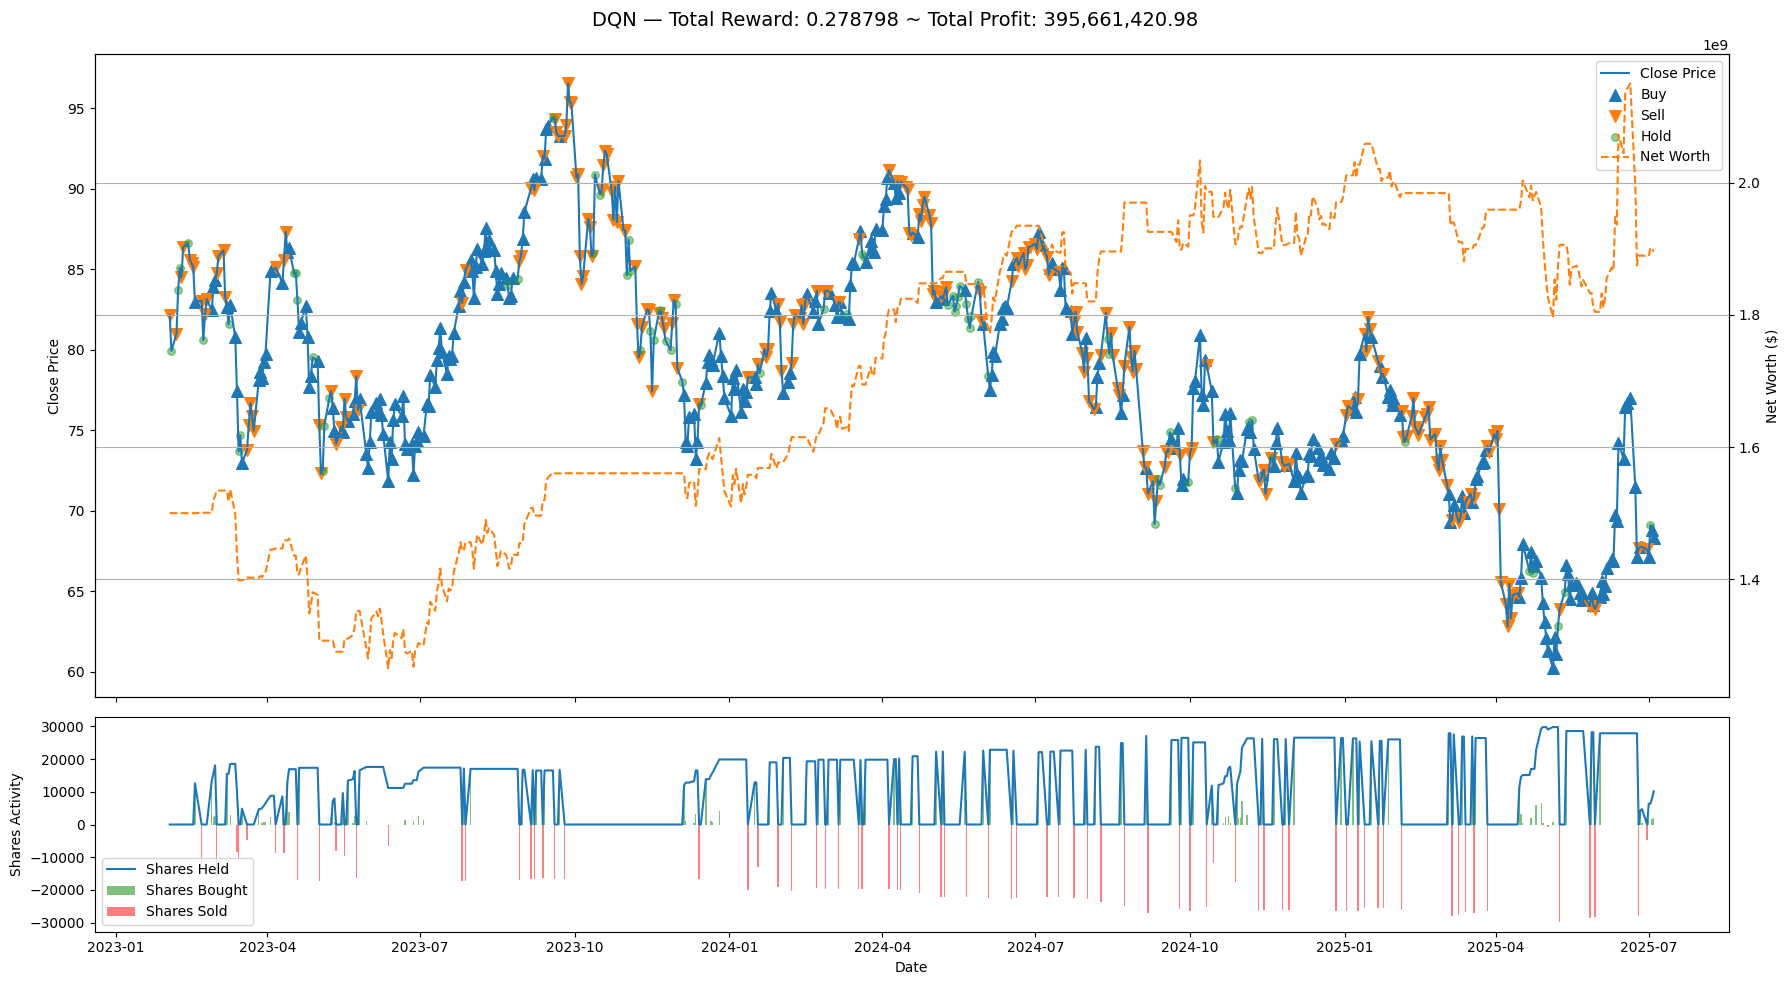

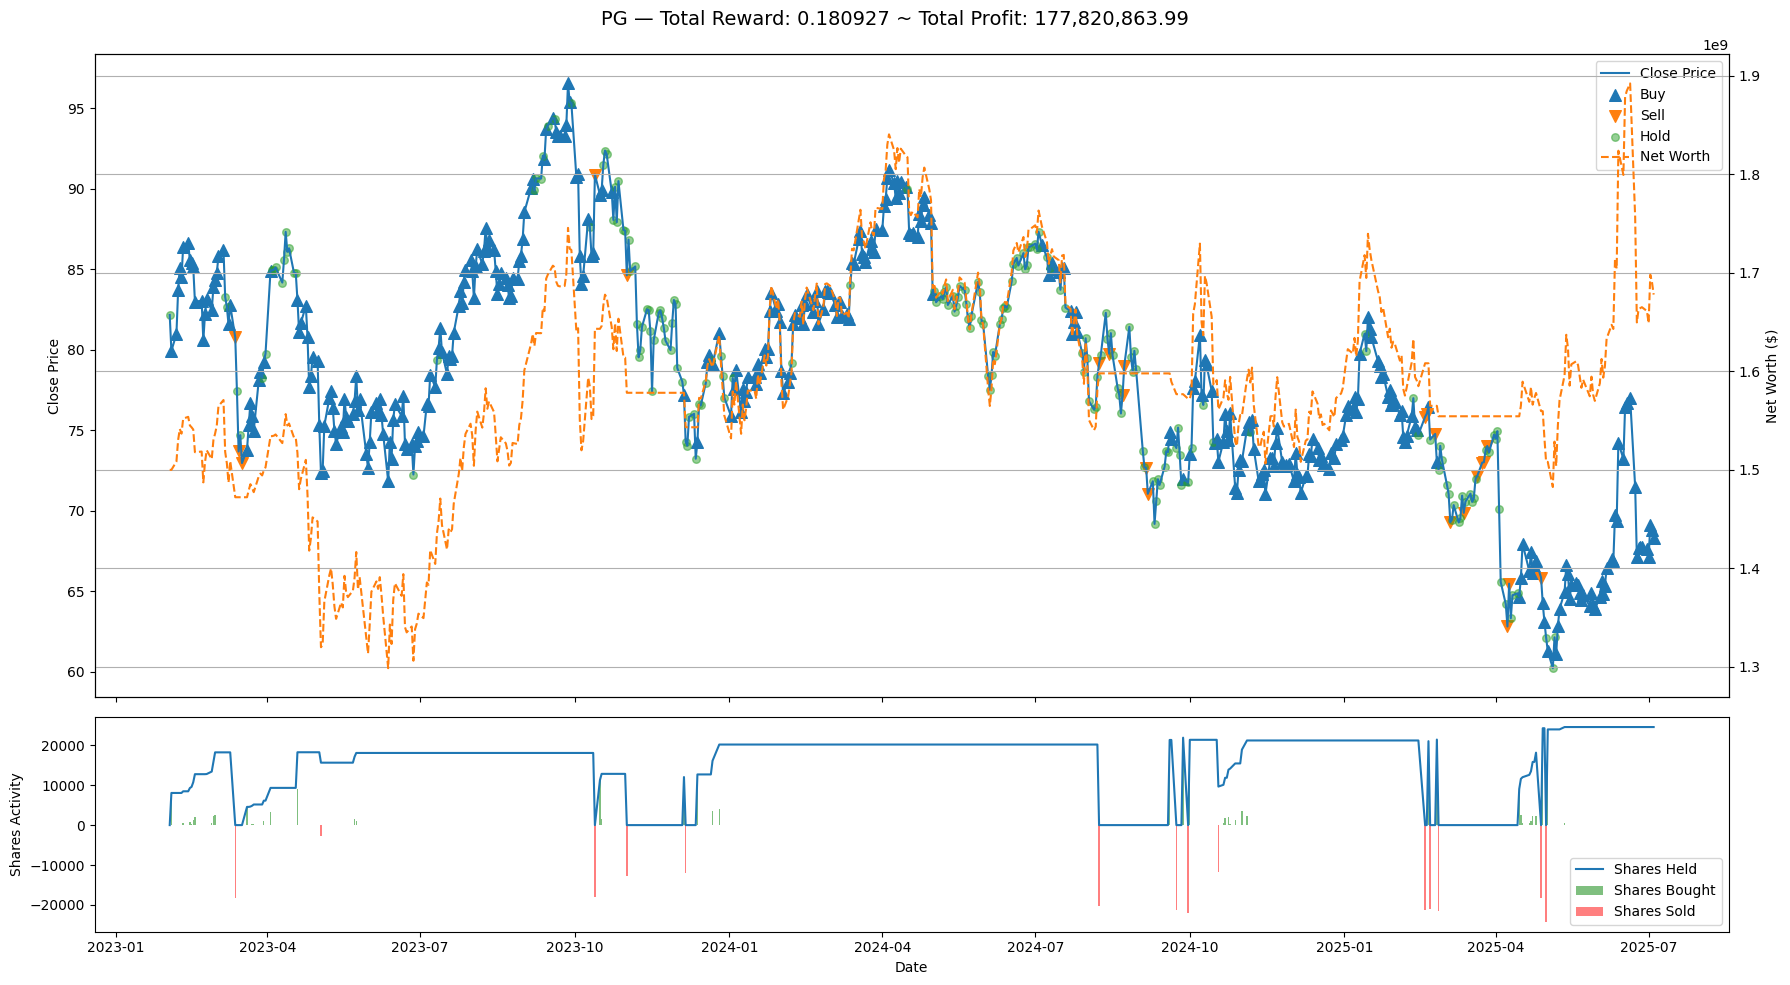

In [ ]:
agents = [("DQN", dqn_model, "dqn"),("PG",  pg_model,  "pg")]

lookback_window = 20
start_capital = 1.5e9
transaction_cost = 3e-5

for name, model, agent_type in agents:
    test_env = TradingEnv(df=test_df, lookback_window=lookback_window, transaction_cost=transaction_cost)
    total_reward, hist_df = test_agent(test_env, model, agent_type=agent_type)
    plot_trades_with_equity_and_share_activity(hist_df,
        title_prefix=f"{name} — Total Reward: {total_reward:.6f}",
        start_capital=start_capital)


In [ ]:
# use helpers
def _validate_history(h: pd.DataFrame) -> pd.DataFrame:
    req = {'Date','Price','NetWorth','Action','Position'}
    missing = req - set(h.columns)
    if missing:
        raise ValueError(f"history_df missing columns: {missing}")
    out = h.copy()
    out['Date'] = pd.to_datetime(out['Date'])
    out = out.sort_values('Date')
    # coerce numerics
    for c in ['Price','NetWorth','Action','Position']:
        out[c] = pd.to_numeric(out[c], errors='coerce')
    out = out.dropna(subset=['Date','Price','NetWorth','Action','Position'])
    return out

def _vol_regimes_from_price(px: pd.Series, vol_window=63):
    """Return (vol_annual, regime_series) with regimes {0:low,1:mid,2:high} by vol terciles."""
    ret = px.pct_change()
    vol = ret.rolling(vol_window).std() * np.sqrt(252)
    q1, q2 = vol.quantile([0.33, 0.66])
    regime = pd.Series(np.where(vol <= q1, 0, np.where(vol <= q2, 1, 2)), index=vol.index)
    return vol, regime

def _action_series(h: pd.DataFrame) -> pd.Series:
    """Datetime-indexed action series."""
    hh = _validate_history(h)
    s = pd.Series(hh['Action'].values, index=hh['Date'])
    return s.sort_index().astype(int)

def plot_regime_overlay(history: pd.DataFrame, vol_window=63, title="Price with Volatility Regimes & Actions"):
    h = _validate_history(history).set_index('Date')
    px = h['Price']
    vol, regime = _vol_regimes_from_price(px, vol_window=vol_window)

    ymin, ymax = float(px.min()), float(px.max())
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(px.index, px.values, label="Price")

    # shaded regimes
    ax.fill_between(px.index, ymin, ymax, where=(regime==2), alpha=0.15, label="High vol")
    ax.fill_between(px.index, ymin, ymax, where=(regime==1), alpha=0.10, label="Mid vol")

    # actions
    buy_idx  = h['Action'] == 1
    sell_idx = h['Action'] == 2
    ax.scatter(h.index[buy_idx],  px[buy_idx],  marker='^', s=30, label='Buy',  alpha=0.7)
    ax.scatter(h.index[sell_idx], px[sell_idx], marker='v', s=30, label='Sell', alpha=0.7)

    ax.set_title(title)
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_position_distribution(agent_histories: dict, bins=None, title="Distribution of Positions (# Contracts)"):
    # infer integer-centered bins across all agents if not provided
    if bins is None:
        all_vals = []
        for h in agent_histories.values():
            hh = _validate_history(h)
            all_vals.append(pd.to_numeric(hh['Position'], errors='coerce'))
        all_vals = pd.concat(all_vals).dropna()
        if all_vals.empty:
            raise ValueError("No valid Position values found.")
        vmin, vmax = int(np.floor(all_vals.min())), int(np.ceil(all_vals.max()))
        bins = np.arange(vmin - 0.5, vmax + 1.5)  # centers on integers

    plt.figure(figsize=(10,6))
    for name, hist in agent_histories.items():
        hh = _validate_history(hist)
        vals = pd.to_numeric(hh['Position'], errors='coerce').dropna().astype(float)
        plt.hist(vals, bins=bins, histtype='step', density=True, label=name)
    plt.title(title)
    plt.xlabel("Position (# contracts)")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Action distribution comparisons
def plot_action_counts(agent_histories: dict, title="Action Counts by Model"):
    """
    Grouped bar chart of absolute action counts (Hold/Buy/Sell) per agent.
    """
    labels = []
    counts = []
    for name, h in agent_histories.items():
        a = _action_series(h)
        labels.append(name)
        counts.append([(a==0).sum(), (a==1).sum(), (a==2).sum()])
    counts = np.array(counts)  # shape (n_agents, 3)
    holds, buys, sells = counts[:,0], counts[:,1], counts[:,2]

    x = np.arange(len(labels)); w = 0.25
    plt.figure(figsize=(10,5))
    plt.bar(x - w, holds, width=w, label="Hold (0)")
    plt.bar(x,       buys,  width=w, label="Buy (1)")
    plt.bar(x + w,   sells, width=w, label="Sell (2)")
    plt.xticks(x, labels, rotation=15)
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_action_mix(agent_histories: dict, title="Action Mix by Model (%)"):
    """
    Stacked percentage bar of action mix per agent.
    """
    labels = []
    counts = []
    for name, h in agent_histories.items():
        a = _action_series(h)
        labels.append(name)
        counts.append([(a==0).sum(), (a==1).sum(), (a==2).sum()])
    counts = np.array(counts).astype(float)
    totals = counts.sum(axis=1)
    pct = np.divide(counts, totals[:,None], out=np.zeros_like(counts), where=totals[:,None]>0)
    p_hold, p_buy, p_sell = pct[:,0], pct[:,1], pct[:,2]

    plt.figure(figsize=(10,5))
    bottom = np.zeros(len(labels))
    plt.bar(labels, p_hold, label="Hold (0)", bottom=bottom)
    bottom += p_hold
    plt.bar(labels, p_buy,  label="Buy (1)",  bottom=bottom)
    bottom += p_buy
    plt.bar(labels, p_sell, label="Sell (2)", bottom=bottom)
    plt.ylabel("Share")
    plt.ylim(0, 1)
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Action mix conditioned on volatility regimes
def plot_action_mix_by_regime(agent_histories: dict, vol_window=63, title="Action Mix by Volatility Regime"):
    """
    For each agent: compute % of actions taken in low/mid/high vol regimes and show as 3 grouped bars.
    Regimes: terciles of rolling annualized volatility (window=vol_window).
    """
    # Build a common regime from the *price* in the first agent (assumes same market/period)
    first_hist = next(iter(agent_histories.values()))
    hh = _validate_history(first_hist).set_index('Date')
    px = hh['Price']
    _, regime = _vol_regimes_from_price(px, vol_window=vol_window)

    # Prepare figure
    labels = list(agent_histories.keys())
    low_mix, mid_mix, high_mix = [], [], []

    for name, h in agent_histories.items():
        a = _action_series(h)                         # agent actions
        df = pd.DataFrame({"action": a}).join(regime.rename("regime"), how="inner").dropna()
        # share of actions in each regime (any action 0/1/2 counts equally)
        total = len(df)
        if total == 0:
            low_mix.append(0.0); mid_mix.append(0.0); high_mix.append(0.0)
            continue
        low_mix.append((df['regime']==0).sum()/total)
        mid_mix.append((df['regime']==1).sum()/total)
        high_mix.append((df['regime']==2).sum()/total)

    x = np.arange(len(labels)); w = 0.25
    plt.figure(figsize=(10,5))
    plt.bar(x - w, low_mix,  width=w, label="Low vol")
    plt.bar(x, mid_mix, width=w, label="Mid vol")
    plt.bar(x + w,high_mix,width=w, label="High vol")
    plt.xticks(x,labels, rotation=15)
    plt.ylabel("Share of Actions")
    plt.ylim(0, 1)
    plt.title(title + f" (window={vol_window})")
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


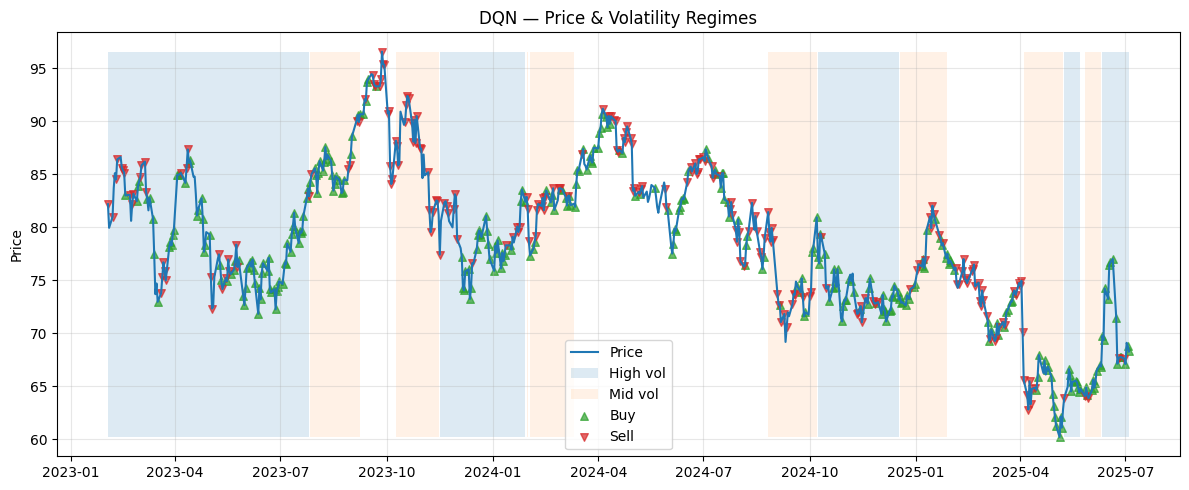

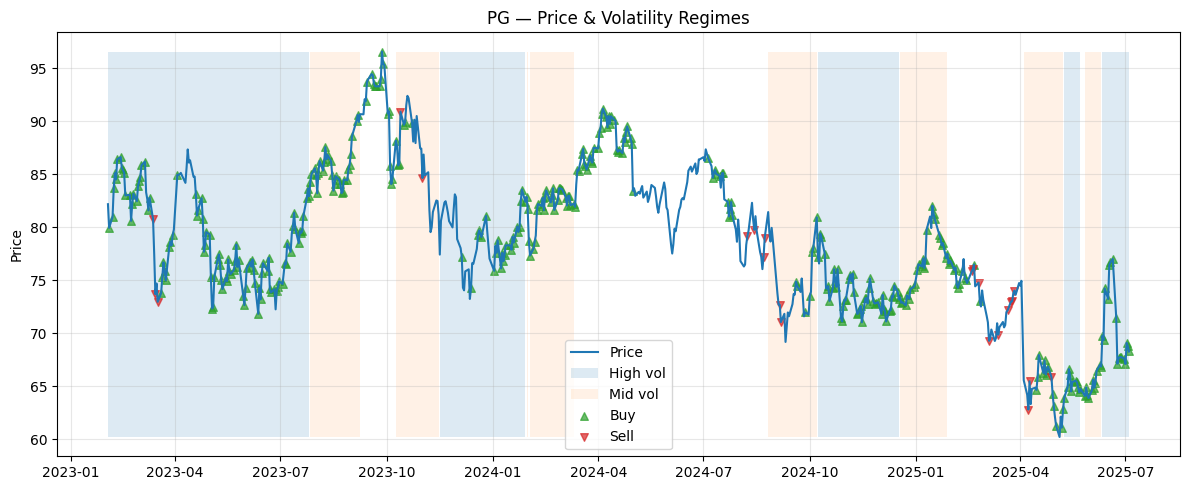

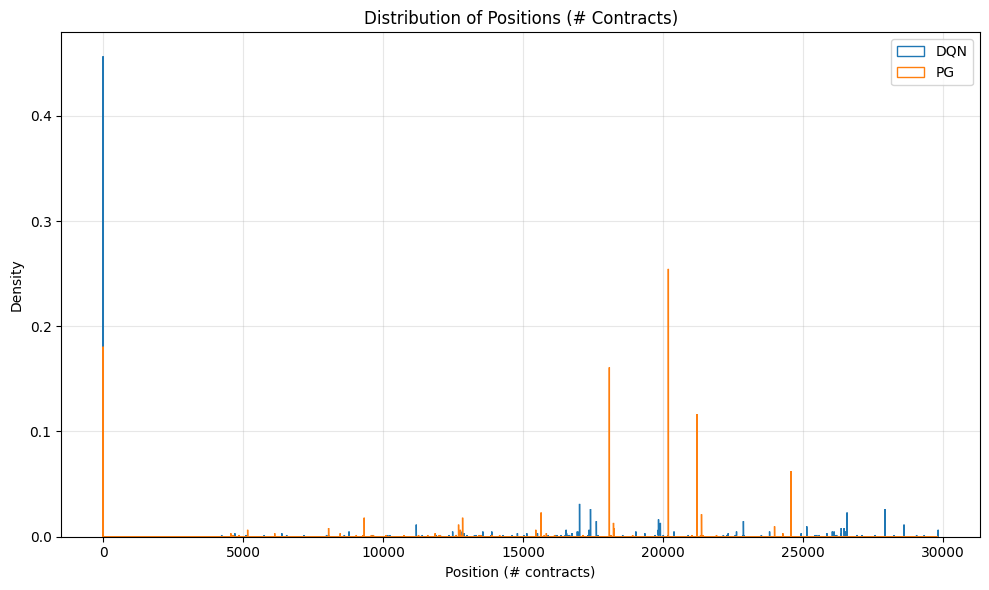

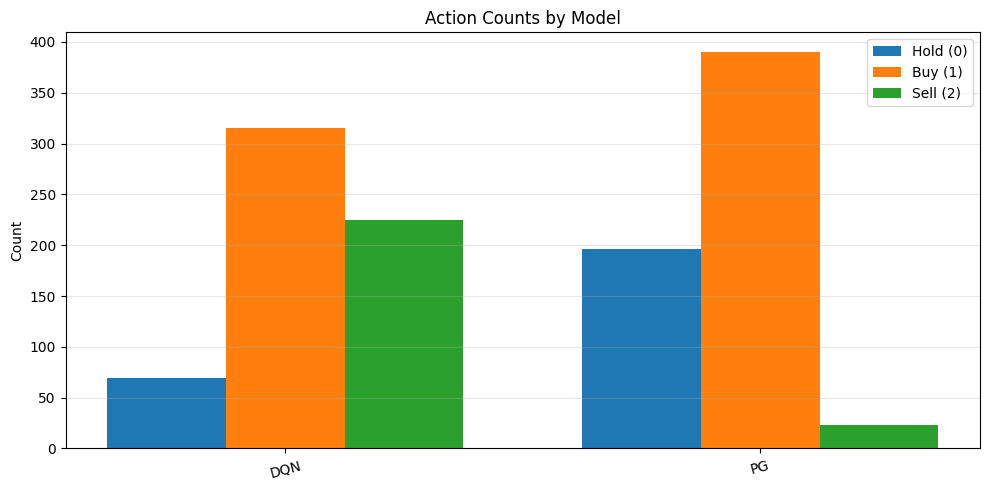

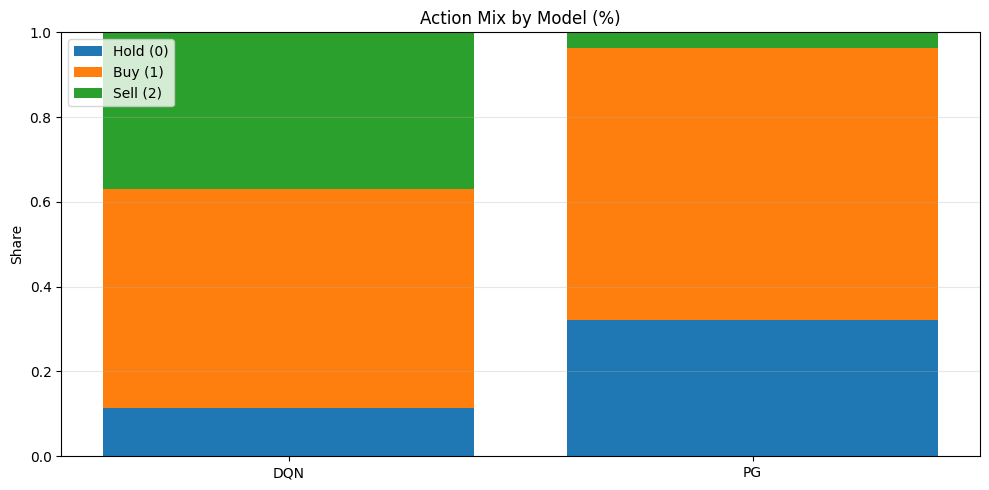

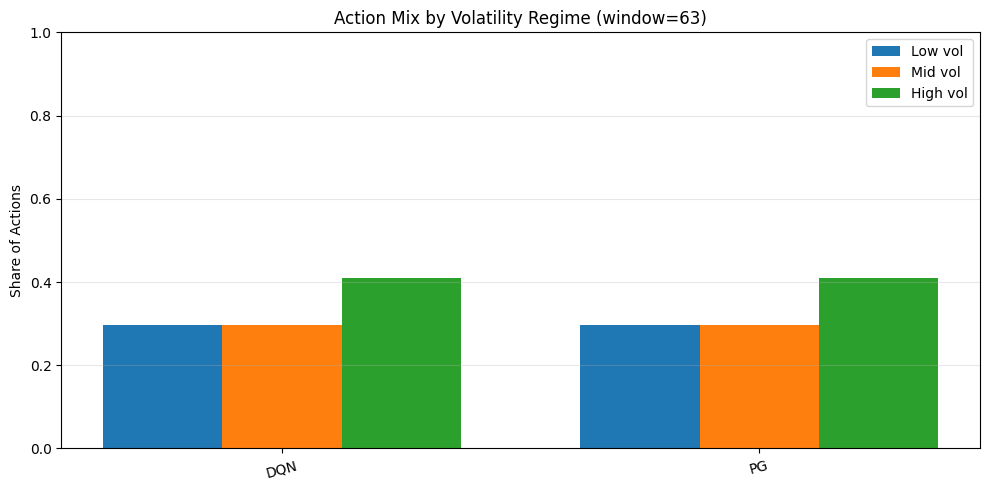

In [ ]:
agents = [("DQN", dqn_model, "dqn"), ("PG", pg_model, "pg")]
lookback_window = 20
start_capital = 1.5e9
transaction_cost = 3e-5

agent_histories = {}
for name, model, agent_type in agents:
    env = TradingEnv(df=test_df, lookback_window=lookback_window, transaction_cost=transaction_cost)
    total_reward, h = test_agent(env, model, agent_type=agent_type)
    agent_histories[name] = h

# regime per agent
plot_regime_overlay(agent_histories["DQN"], vol_window=63, title="DQN — Price & Volatility Regimes")
plot_regime_overlay(agent_histories["PG"],  vol_window=63, title="PG — Price & Volatility Regimes")

# position distribution across agents
plot_position_distribution(agent_histories)

# action distribution comparisons
plot_action_counts(agent_histories)
plot_action_mix(agent_histories)
plot_action_mix_by_regime(agent_histories, vol_window=63)


In [ ]:
# helpers reused
def _validate_history(h: pd.DataFrame, need_units=True) -> pd.DataFrame:
    base_req = {'Date','Price','Action','Position'}
    req = base_req | ({'UnitsBuy','UnitsSell'} if need_units else set())
    missing = req - set(h.columns)
    out = h.copy()
    out['Date'] = pd.to_datetime(out['Date'])
    out = out.sort_values('Date')
    # coerce numerics
    for c in (set(out.columns) & {'Price','NetWorth','Action','Position','UnitsBuy','UnitsSell'}):
        out[c] = pd.to_numeric(out[c], errors='coerce')
    out = out.dropna(subset=['Date','Price','Action','Position'])
    # if Units not present, derive from Position diffs
    if 'UnitsBuy' not in out.columns or 'UnitsSell' not in out.columns:
        out['PrevPosition'] = out['Position'].shift(1).fillna(0)
        out['UnitsBuy']  = np.where(out['Position'] > out['PrevPosition'],  out['Position'] - out['PrevPosition'], 0)
        out['UnitsSell'] = np.where(out['Position'] < out['PrevPosition'],  out['PrevPosition'] - out['Position'], 0)
    return out

def _vol_regimes_from_price(px: pd.Series, vol_window=63):
    """Regimes {0:low,1:mid,2:high} by terciles of rolling ann. volatility as explained in thesis. I pasted below this box as well"""
    ret = px.pct_change()
    vol = ret.rolling(vol_window).std() * np.sqrt(252)
    q1, q2 = vol.quantile([0.33, 0.66])
    regime = pd.Series(np.where(vol <= q1, 0, np.where(vol <= q2, 1, 2)), index=vol.index)
    return vol, regime

# main: plot contracts bought/sold by regime for multiple agents
def plot_contracts_by_vol_regime(agent_histories: dict, vol_window=63, title="Contracts Bought/Sold by Volatility Regime"):
    """agent_histories: {"Agent Name": history_df, ...}
    Uses UnitsBuy/UnitsSell if available; otherwise reconstructs from Position deltas."""
    # Build a common regime timeline from the first agent's price (assumes same market & dates)
    first_hist = next(iter(agent_histories.values()))
    H0 = _validate_history(first_hist, need_units=False)
    H0 = H0.set_index('Date')
    px0 = H0['Price']
    _, regime = _vol_regimes_from_price(px0, vol_window=vol_window)  # index: Date, values 0/1/2

    # Aggregate buys/sells per regime for each agent
    regime_labels = {0: "Low", 1: "Mid", 2: "High"}
    agents = list(agent_histories.keys())
    buys_mat  = np.zeros((len(agents), 3), dtype=float)
    sells_mat = np.zeros((len(agents), 3), dtype=float)

    for i, (name, hist) in enumerate(agent_histories.items()):
        H = _validate_history(hist, need_units=True).set_index('Date')
        J = H[['UnitsBuy','UnitsSell']].join(regime.rename('regime'), how='inner').dropna(subset=['regime'])
        for r in (0, 1, 2):
            mask = (J['regime'] == r)
            buys_mat[i, r]  = float(J.loc[mask, 'UnitsBuy'].sum())
            sells_mat[i, r] = float(J.loc[mask, 'UnitsSell'].sum())

    # Plot: two subplots (Buys on left, Sells on right), grouped by regime with bars per agent
    x = np.arange(3)  # regimes 0/1/2
    width = 0.8 / max(1, len(agents))  # fit all agents within each regime cluster

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    for i, name in enumerate(agents):
        axes[0].bar(x + i*width - 0.4 + width/2, buys_mat[i], width=width, label=name)
        axes[1].bar(x + i*width - 0.4 + width/2, sells_mat[i], width=width, label=name)

    for ax, ylabel, mat in zip(axes, ["Contracts Bought", "Contracts Sold"], [buys_mat, sells_mat]):
        ax.set_xticks(x)
        ax.set_xticklabels([regime_labels[r] for r in (0,1,2)])
        ax.set_ylabel(ylabel)
        ax.grid(True, axis="y", alpha=0.3)

    axes[0].set_title(f"Buys by Vol Regime (window={vol_window})")
    axes[1].set_title(f"Sells by Vol Regime (window={vol_window})")
    # one legend for both
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left", ncol=min(len(agents), 4), frameon=False)
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
##################################################################################
# We compute annualized volatility over the past 63 days, then classify each day into low, medium, or high volatility depending on where today’s volatility sits in the distribution of the sample.”

# # how we define the market regimes in the plots:
#ret = px.pct_change()
#vol = ret.rolling(vol_window).std() * np.sqrt(252)
#Multiplying by sqrt(252) annualizes it (so it’s comparable across horizons).
#Regimes are then split into terciles (three groups):

#Low volatility = when rolling vol ≤ 33rd percentile (q1)

#Mid volatility = between 33rd–66th percentile (q2)

#High volatility = above the 66th percentile

#“Volatility regime” uses rolling 63-day annualized vol and terciles;
# Volatility is measured as the rolling standard deviation of returns.

# vol_window=63 means a 63-day rolling window ( one quarter of trading days).

# The chart shows absolute contract counts.


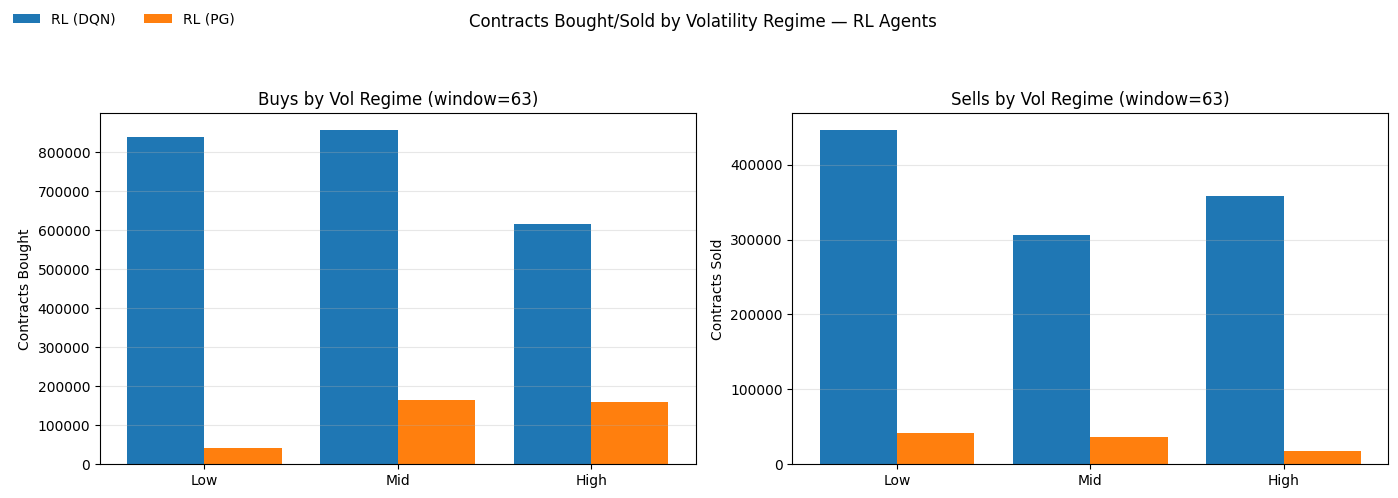

In [ ]:
#DQN vs PG contract activity by volatility regime
agent_histories = {
    "RL (DQN)": dqn_hist_test,
    "RL (PG)" : pg_hist_test,
}

plot_contracts_by_vol_regime(agent_histories, vol_window=63,
    title="Contracts Bought/Sold by Volatility Regime — RL Agents")
